# **Introduction**

This notebook presents an end-to-end topic modelling workflow applied to earnings call transcripts from major UK and global banks.  
The objective is to extract and interpret dominant discussion themes using **BERTopic** and align them with **PRA risk categories** for supervisory insight.  

By combining **transformer-based embeddings**, **unsupervised clustering**, and **semantic similarity mapping**, the analysis reveals how banks communicate around key risk and regulatory themes such as capital adequacy, liquidity, governance, and credit quality.


## **1. Imports & Preparation**

This section sets up the core environment for the NLP pipeline.


In [1]:
%pip install bertopic sentence-transformers gensim pyLDAvis numpy pandas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import re
import string
import wordcloud

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import plotly.graph_objects as go
import plotly.express as px
import plotly.colors as pc

from gensim import corpora
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import warnings

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# ignore warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [4]:
# Clone the GitHub repository
!git clone https://github.com/JSA10/cam_ds_ep_FinSight

fatal: destination path 'cam_ds_ep_FinSight' already exists and is not an empty directory.


In [5]:
# List files in the cloned repository
!ls cam_ds_ep_FinSight/data/processed/jpm/

all_jpm_2023_2025.csv
all_jpm_2025.csv
cleaned
jpm-1q23-earnings-call-transcript-checkpoint_qa.csv
jpm-1q23-earnings-call-transcript_qa.csv
jpm-1q24-earnings-call-transcript_qa.csv
jpm-1q25-earnings-call-transcript-checkpoint_qa.csv
jpm-1q25-earnings-call-transcript_qa.csv
jpm-2q23-earnings-call-transcript_qa.csv
jpm-2q24-earnings-call-transcript_qa.csv
jpm-2q25-earnings-call-transcript-checkpoint_qa.csv
jpm-2q25-earnings-call-transcript_qa.csv
jpm-3q23-earnings-call-transcript-checkpoint_qa.csv
jpm-3q23-earnings-call-transcript_qa.csv
jpm-3q24-earnings-conference-call-transcript_qa.csv
jpm-4q23-earnings-call-transcript_qa.csv
jpm-4q24-earnings-transcript-checkpoint_qa.csv
jpm-4q24-earnings-transcript_qa.csv


#### **PRA Categories**

The Prudential Regulation Authority defines thematic categories of risk and control across the banking sector.  
Here we load the PRA risk taxonomy that will later serve as a reference framework to map the model-extracted topics into recognisable regulatory themes such as Capital Adequacy, Liquidity, Governance & Credit Risk.

These categories are essential for linking unsupervised model outputs to our research questions.


In [6]:
pra_categories = pd.read_csv('cam_ds_ep_FinSight/data/RAG-resources/PRA_risk_categories.csv')
pra_categories

,category,definition
0,Capital adequacy,"""Sufficiency of capital to absorb losses; CET1..."
1,Liquidity,"""Ability to meet obligations as they fall due;..."
2,Credit risk,"""Counterparty default/credit deterioration; pr..."
3,Market risk,"""P&L volatility from market movements; VaR, se..."
4,Operational risk,"""Loss from processes/people/systems; cyber, fr..."
5,Conduct risk,"""Customer outcomes and market integrity; mis-s..."
6,Governance,"""Board oversight, controls, risk culture, remu..."
7,Risk management,"""Risk frameworks, appetite, limits, aggregatio..."
8,Stress testing,"""Outcomes under stress scenarios; capital and ..."


In [47]:
# PRA risk category keywords for BERTopic topic mapping

pra_core_topic_list = {
    "Capital Adequacy": [
        "capital adequacy", "capital ratio", "CET", "Tier one", "Tier two", "buffers",
        "regulatory capital", "ICAAP", "Pillar one", "Pillar two", "RWAs",
        "leverage ratio", "solvency", "capital plan", "loss absorption"
    ],

    "Liquidity": [
        "liquidity", "LCR", "NSFR", "funding", "cash flow", "maturity mismatch",
        "stress outflows", "liquid assets", "high-quality liquid assets",
        "funding profile", "liquidity buffer", "intraday liquidity", "run-off rates",
        "liquidity risk appetite"
    ],

    "Credit Risk": [
        "credit risk", "counterparty", "default", "provisioning", "impairments", "ECL",
        "PD", "LGD", "NPL", "credit exposure", "credit quality",
        "concentration risk", "credit limits", "underwriting", "credit assessment",
        "IFRS 9"
    ],

    "Market Risk": [
        "market risk", "value at risk", "VaR", "P&L volatility", "interest rate risk",
        "FX risk", "trading book", "sensitivities", "market movements", "equity risk",
        "IRRBB", "mark-to-market", "stress VaR", "positions", "derivatives"
    ],

    "Operational Risk": [
        "operational risk", "cyber risk", "fraud", "process failure", "internal controls",
        "IT outage", "resilience", "third-party risk", "technology risk", "people risk",
        "data loss", "KRI", "business continuity", "operational loss"
    ],

    "Conduct Risk": [
        "conduct risk", "mis-selling", "customer harm", "fair treatment",
        "conflicts of interest", "culture", "incentive structures", "product governance",
        "market integrity", "FCA", "SMCR", "complaints", "customer outcomes", "redress"
    ],

    "Governance": [
        "governance", "board oversight", "risk committee", "risk culture",
        "accountability", "decision-making", "control environment", "senior management",
        "remuneration", "incentives", "internal audit", "three lines of defence", "tone from the top"
    ],

    "Risk Management": [
        "risk management", "risk framework", "risk appetite", "limits",
        "risk aggregation", "risk reporting", "control framework", "escalation",
        "risk challenge", "monitoring", "policy", "governance", "dashboards", "MI"
    ],

    "Stress Testing": [
        "stress testing", "scenario analysis", "capital impact", "liquidity impact",
        "reverse stress", "macroeconomic scenarios", "adverse scenario",
        "PRA stress test", "climate stress", "systemic risk", "projections",
        "resilience testing"
    ]
}


# **2. BERTopic Modelling**

We use a transformer-based topic modelling framework ( **BERTopic**) to extract coherent themes from earnings call transcripts.  

- Embeddings are generated via **SentenceTransformers** to capture semantic similarity.
- A custom stop words list is implemented to reduce conversational noise.
- Clustering is guided using a seed topic list to better align the themes raised with those of interest to the PRA.
- The resulting topics represent dominant discussion themes in analyst calls, reflecting financial and strategic priorities.  


\
\
The outputs include:
- Topic assignments per text segment  
- Representative keywords for each topic  
- Visual summaries of topic prevalence  

## JP Morgan Analysis

In [96]:
# Import JPM data
jpm_full_23_25 = pd.read_csv('cam_ds_ep_FinSight/data/processed/jpm/all_jpm_2023_2025.csv')

# Filter & clean the data
jpm_full_23_25 = jpm_full_23_25[jpm_full_23_25['is_pleasantry'] == False]
jpm_full_23_25 = jpm_full_23_25[~jpm_full_23_25['source_pdf'].str.contains('checkpoint', na=False)]
jpm_full_23_25.drop(columns=['source_pdf'], inplace=True) # 'is_pleasantry'
jpm_full_23_25.reset_index(drop=True, inplace=True)
jpm_full_23_25

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False
1,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False
2,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False
3,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False
4,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False
...,...,...,...,...,...,...,...,...,...,...
787,qa,14.0,3.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"No, no, no. You go. Seriously.",2024,Q4,False
788,qa,14.0,4.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorganChase,I was just going to say we're not going to do ...,2024,Q4,False
789,qa,14.0,5.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"If anyone has a different opinion, we're alway...",2024,Q4,False
790,qa,14.0,5.0,"Analyst, RBC Capital Markets LLC",analyst,gentlemen.,NaN,2024,Q4,False


In [69]:
# Preprocessing function

def clean_text_for_bertopic(text):
  if not isinstance(text, str):
    return "" # Return empty string for non-string input
  text = text.lower()
  text = re.sub(r'\d+', '', text)
  text = re.sub(f'[{re.escape(string.punctuation)}\u2019\2018]' , '', text)
  return text


In [97]:
jpm_full_23_25['clean_text'] = jpm_full_23_25['content'].apply(clean_text_for_bertopic)
jpm_full_23_25['clean_text']

,clean_text
0,thanks and good morning everyone the presentat...
1,so jamie i was actually hoping to get your per...
2,well i think you were already kind of complete...
3,got it and just in terms of appetite for the b...
4,oh yeah
...,...
787,no no no you go seriously
788,i was just going to say were not going to do o...
789,if anyone has a different opinion were always ...
790,


In [98]:
# Convert the array into a list for BERTopic
jpm_topic_input = jpm_full_23_25['clean_text'].tolist() # tolist() alternative
print(jpm_topic_input)

['thanks and good morning everyone the presentation is available on our website and please refer to the disclaimer on the back starting on page  the firm reported net income of  billion eps of  on revenue of  billion and delivered an rotce of  these results included  million of net investment securities losses in corporate before reviewing our results for the quarter lets talk about the recent bank failures jamie has addressed a number of the important themes in his shareholder letter and a recent televised interview so i will go straight to the specific impacts on the firm as you would expect we saw significant new account opening activity and meaningful deposit and money market fund inflows most significantly in the commercial bank business banking and awm regarding the deposit inflows at the firmwide level average deposits were down  quarteronquarter while endofperiod deposits were up  quarteronquarter – implying an intraquarter reversal of the recent outflow trend as a consequence 

In [99]:
# Input Sample
jpm_topic_input[97]

'yeah good question jim i think the simplest and best answer to that is not really so as weve been saying for a while migration from checking and savings to cds is sort of the dominant trend with this driving the increase in weighted average rate paid in the consumer deposit franchise that continues we continue to capture that moneyinmotion at a very high rate were very happy about what that means about the consumer franchise and level of engagement that were seeing im aware that theres a little bit of a narrative out there about are we seeing the end of what people sometimes refer to as cash sorting weve looked at that data we see some evidence that maybe its slowing a little bit were quite cautious on that we really sort of dont think it makes sense to assume that in a world where checking and savings is paying effectively zero and the policy rate is above  that youre not going to see ongoing migration and frankly we expect to see that even in a world where – even if the current yiel

**Merging BERTopic with a finance-specific model embeddings (FinBERT & Baconnier/Finance2) produced better topic recognition.**

In [63]:
from sklearn.feature_extraction.text import CountVectorizer

# Call FinBERT's embeddings for better identification of relevant financial themes
finbert = SentenceTransformer("baconnier/Finance2_embedding_small_en-V1.5")     #'jpaull01/FinBERT-Sentiment-ST', yiyanghkust/finbert-tone

# Filter stopwords from topics using vectorizer
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

custom_stop_words = [
    # Politeness / Social niceties
    'thank', 'thanks', 'please', 'welcome', 'sorry', 'appreciate', 'awesome',
    # Acknowledgements / Agreement / Affirmation
    'okay', 'ok', 'right', 'yeah', 'sure', 'alright', 'well', 'good', 'great', 'excellent',
    'dont', 'didnt', 'havent',
    # Greetings / Conversation Openers
    'hello', 'hi', 'morning', 'afternoon',
    # Common verbs and modal verbs
    'get', 'go', 'make', 'take', 'taking', 'tell', 'know', 'see', 'think', 'guess', 'comes',
    'could', 'would', 'can', 'will', 'might', 'may', 'havent', 'didnt', 'ive', 'weve', 'im', 'ill',
    # Uncertainty / Hedges
    'almost', 'maybe', 'kind', 'bit', 'little', 'might', 'may', 'sorta', 'kinda',  # incl common variants
    # Fillers / Conversation noise
    'lot', 'stuff', 'obviously', 'oh', 'ahead', 'hear', 'followup', 'queue', 'next',
    # People references / Generic audience terms
    'youre', 'guys', 'operator', 'line', 'speak',
    # Questions / Answers / Discussion
    'question', 'questions', 'answer', 'answers',
    # Finance-specific generalities (often contextually filler)
    'bank', 'banks', 'duration', 'number',
    # Colours / Visual
    'color',
    # Positional / Reference
    'former', 'latter', 'new', 'old',
    # Names
    'ken', 'jeremy', 'jamie', 'georges', 'coombs', 'aman', 'andy', 'rakkar', 'amit', 'ed', 'katherine', 'neil'
    # Slang / Miscellaneous
    'cheap', 'helpful', 'th', 'going'
]

vectorizer = CountVectorizer(stop_words=list(stop_words) + custom_stop_words)


print("Setup complete")

Setup complete


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [87]:
# Apply BERTopic with custom embeddings
topic_model = BERTopic(
    embedding_model=finbert,
    language="english",
    vectorizer_model=vectorizer,
    #nr_topics=15,
    #min_topic_size=10,
    seed_topic_list=pra_core_topic_list
    )


In [88]:
# Perform the topic modelling
jpm_topics, jpm_prob = topic_model.fit_transform(jpm_topic_input)

In [ ]:
# Get topic info
topic_info = topic_model.get_topic_info()
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,241,-1_bit_little_jpmorgan_chase,"[bit, little, jpmorgan, chase, thats, statemen...",[okay thank you very much operator thank you t...
1,0,82,0_go_open_gerard_securities,"[go, open, gerard, securities, cassidy, fargo,...",[got it okay thank you operator next well go t...
2,1,72,1_capital_basel_iii_endgame,"[capital, basel, iii, endgame, things, billion...",[remember we can do a lot of things to change ...
3,2,54,2_nii_curve_little_bit,"[nii, curve, little, bit, yield, number, year,...",[– that theres lots of different offsetting fa...
4,3,53,3_lending_private_credit_market,"[lending, private, credit, market, space, capi...",[yeah thanks glenn so on private credit so not...
5,4,51,4_lot_thats_obviously_get,"[lot, thats, obviously, get, bit, im, economy,...",[sure ken so i mean at a high level i would sa...
6,5,48,5_ahead_hear_go_oh,"[ahead, hear, go, oh, followup, hello, cheap, ...","[go ahead, no no jeremy go ahead, go ahead jer..."
7,6,46,6_dont_know_ive_tell,"[dont, know, ive, tell, didnt, almost, make, n...",[yeah i mean the hedges are definitely part of...
8,7,43,7_deposit_deposits_migration_rate,"[deposit, deposits, migration, rate, thats, co...",[yeah sure so i think what youre referring to ...
9,8,30,8_got_appreciate_helpful_color,"[got, appreciate, helpful, color, alright, ill...","[got it, got it okay all right thank you, got ..."


In [ ]:
# Visualise the top 5 words each topic
topic_model.visualize_barchart(top_n_topics=50, n_words=10, title="Topic word scores",
                               width=300, height=300)

In [ ]:
# Visualise the Topic distributions
topic_model.visualize_topics()

In [29]:
# Create interpretable labels from top words
def get_custom_labels(topic_model, n_words):
    topic_labels = {}
    for topic_id in topic_model.get_topics().keys():
        if topic_id == -1:  # Create an Outlier cluster
            topic_labels[topic_id] = "Outliers"
            continue
        words = [w for w, _ in topic_model.get_topic(topic_id)[:n_words]]
        label = " / ".join(words)   # joins top words into readable string
        topic_labels[topic_id] = label
    return topic_labels

# Generate the labels
jpm_label_dict = get_custom_labels(topic_model, n_words=10)

# Apply topic IDs back to the main dataframe
jpm_full_23_25["Topic"] = jpm_topics
jpm_full_23_25["topic_label"] = jpm_full_23_25["Topic"].map(jpm_label_dict)


In [30]:
jpm_full_23_25

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,clean_text,Topic,topic_label
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,thanks and good morning everyone the presentat...,0,billion / thats / bit / little / capital / hig...
1,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,so jamie i was actually hoping to get your per...,0,billion / thats / bit / little / capital / hig...
2,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,well i think you were already kind of complete...,0,billion / thats / bit / little / capital / hig...
3,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,got it and just in terms of appetite for the b...,0,billion / thats / bit / little / capital / hig...
4,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,oh yeah,0,billion / thats / bit / little / capital / hig...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,qa,14.0,3.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"No, no, no. You go. Seriously.",2024,Q4,False,no no no you go seriously,0,billion / thats / bit / little / capital / hig...
788,qa,14.0,4.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorganChase,I was just going to say we're not going to do ...,2024,Q4,False,i was just going to say were not going to do o...,0,billion / thats / bit / little / capital / hig...
789,qa,14.0,5.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"If anyone has a different opinion, we're alway...",2024,Q4,False,if anyone has a different opinion were always ...,1,go / open / gerard / securities / cassidy / fa...
790,qa,14.0,5.0,"Analyst, RBC Capital Markets LLC",analyst,gentlemen.,NaN,2024,Q4,False,,2,/ / / / / / / / /


## HSBC Analysis

In [110]:
# Explore HSBC files in the cloned repository
!ls cam_ds_ep_FinSight/data/processed/hsbc

all_hsbc_2023_2025.csv
all_hsbc_earnings_data.csv
cleaned
hsbc_230502-1q-2023-hsbc-presentation-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_230802-2q-interim-results-2023-presentation-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_231030-3q-2023-presentation-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_240222-4q-annual-results-2023-presentation-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_240502-1q-2024-hsbc-presentation-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_240801-2q-interim-results-2024-presentation-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_241029-3q-2024-results-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_250220-4q-2024-annual-results-to-investors-and-analysts-transcript_parsed_final.csv
hsbc_250429-1q-2025-earnings-release-investors-and-analysts-call-transcript_parsed_final.csv
hsbc_250731-2q-interim-results-2025-presentation-to-investors-and-analysts-transcript_parsed_final.

In [111]:
# Import HSBC data -- Pleasantries columns can be ignored
hsbc_full_23_25 = pd.read_csv('cam_ds_ep_FinSight/data/processed/hsbc/all_hsbc_2023_2025.csv')
hsbc_full_23_25.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
1,presentation,NaN,NaN,Georges Elhedery,Group Chief Executive,HSBC,"Thank you, Noel, and a warm welcome to all of ...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...


In [58]:
# Preprocess the text
hsbc_full_23_25.drop(columns=['source_pdf'], inplace=True)
hsbc_full_23_25['clean_text'] = hsbc_full_23_25['content'].apply(clean_text_for_bertopic)
hsbc_full_23_25['clean_text']

,clean_text
0,thanks richard and good morning in london good...
1,thank you noel and a warm welcome to all of yo...
2,good morning gentlemen congrats on a good set...
3,thank you joe so first we are hoping to achie...
4,good morning gents thanks very much for takin...
...,...
371,so just to make a comment on fx of course ther...
372,i have three questions the first is that i wou...
373,let me then answer your third question ill ask...
374,we have billion of threshold deductions that...


In [59]:
# Format the input for BERT
hsbc_topic_input = hsbc_full_23_25['clean_text'].tolist()
print(hsbc_topic_input[96])

can i probe you a bit more on the hedging that youve got in place  youve talked about increased hedging for the last couple of quarters and you have this quarter as youve discussed previously taken some losses through the held forsale portfolio to improve that now and next year but we lack an overall understanding of what youve got in terms of the hedge and so my question specifically is how big is your hedge and whats the duration of your hedge so that we can do some modelling to understand how much protection youve got into   and beyond  thank you


In [89]:
# Instantiated a new BERTopic for the HSBC data
hsbc_topic_model = BERTopic(
    embedding_model=finbert,
    language="english",
    vectorizer_model=vectorizer,
    #nr_topics=10,
    #min_topic_size=5,
    seed_topic_list=pra_core_topic_list
    )

print("Setup complete")

Setup complete


In [90]:
hsbc_topics, hsbc_prob = hsbc_topic_model.fit_transform(hsbc_topic_input)

In [91]:
hsbc_topic_info = hsbc_topic_model.get_topic_info()
hsbc_topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,138,-1_one_first_business_year,"[one, first, business, year, growth, us, kong,...",[thank you perlie first yes we recognise ‘hig...
1,0,42,0_billion_quarter_banking_growth,"[billion, quarter, banking, growth, year, last...",[thanks georges in summary we had another good...
2,1,33,1_nii_banking_billion_rates,"[nii, banking, billion, rates, rate, look, sen...",[thank you and rew so obviously today we canno...
3,2,29,2_cost_costs_year_us,"[cost, costs, year, us, growth, million, billi...",[yes thats fair listen youre absolutely right ...
4,3,23,3_much_nob_perfect_le,"[much, nob, perfect, le, understood, offline, ...","[thank you very much ed, okay thank you very ..."
5,4,21,4_sankoff_neil_lets_one,"[sankoff, neil, lets, one, kunpeng, ask, comme...",[neil sankoff thank you lets go back to the ca...
6,5,20,5_cre_ecl_hong_kong,"[cre, ecl, hong, kong, stage, book, charge, ec...",[thank you katherine im going to ask pam to ad...
7,6,16,6_growth_loan_rwa_capital,"[growth, loan, rwa, capital, term, buyback, se...",[first as you know t he proceeds of the sale o...
8,7,15,7_wealth_growth_hong_kong,"[wealth, growth, hong, kong, quarter, assets, ...",[on the nonnii wealth in asia you will observe...
9,8,14,8_trade_scenario_downside_tariffs,"[trade, scenario, downside, tariffs, tariff, i...",[thank you kunpeng ill take your first questio...


In [92]:
hsbc_topic_model.visualize_barchart(top_n_topics=50, n_words=10, title="Topic word scores",
                               width=300, height=300)

In [93]:
hsbc_topic_model.visualize_topics()

In [94]:
# Generate topic labels
hsbc_label_dict = get_custom_labels(hsbc_topic_model, n_words=10)

# Apply topic IDs back to the main dataframe
hsbc_full_23_25["Topic"] = hsbc_topics
hsbc_full_23_25["topic_label"] = hsbc_full_23_25["Topic"].map(hsbc_label_dict)

In [95]:
hsbc_full_23_25

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,clean_text,Topic,topic_label,pra_category,pra_categories
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,thanks richard and good morning in london good...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.317), (Governance, 0.295..."
1,presentation,NaN,NaN,Georges Elhedery,Group Chief Executive,HSBC,"Thank you, Noel, and a warm welcome to all of ...",2023,Q1,True,thank you noel and a warm welcome to all of yo...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.317), (Governance, 0.295..."
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,good morning gentlemen congrats on a good set...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,thank you joe so first we are hoping to achie...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.317), (Governance, 0.295..."
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,good morning gents thanks very much for takin...,6,growth / loan / rwa / capital / term / buyback...,Unmapped,[Unmapped]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,qa,NaN,2.0,Pam Kaur,management,HSBC,"So, just to make a comment on FX, of course th...",2025,Q2,False,so just to make a comment on fx of course ther...,1,nii / banking / billion / rates / rate / look ...,Liquidity,"[(Liquidity, 0.268)]"
372,qa,8.0,NaN,Katherine Lei,Analyst,JP Morgan,I have three questions. The first is that I wo...,2025,Q2,False,i have three questions the first is that i wou...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
373,qa,NaN,1.0,Georges Elhedery,management,HSBC,Let me then answer your third question; I’ll a...,2025,Q2,False,let me then answer your third question ill ask...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
374,qa,NaN,2.0,Pam Kaur,management,HSBC,We have $14 billion of threshold deductions - ...,2025,Q2,False,we have billion of threshold deductions that...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"


# **3. Embeddings-based PRA category matching**



We leverage semantic similarity between extracted topic embeddings and PRA category embeddings to create an interpretable bridge between **unsupervised topics** and **regulatory language**.

This involves:
- Generating embeddings for PRA category definitions  
- Computing cosine similarity between each topic and each PRA category  
- Assigning the most semantically aligned PRA theme to each topic  
- Adding a new column to the respective dataframes to support aggregated analysis and visualisation.



In [104]:
# Turn PRA keyword lists into natural-like text
pra_category_texts = {
    category: " ".join(keywords) for category, keywords in pra_core_topic_list.items()
}

# Encode each category's keyword text
pra_category_names = list(pra_category_texts.keys())
pra_category_embeddings = finbert.encode(list(pra_category_texts.values()), convert_to_tensor=True)


import torch
import numpy as np
from sentence_transformers.util import cos_sim

def get_most_similar_pra_category(topic_label, category_names, category_embeddings, model, threshold=0.25):
    # Encode topic label
    topic_embedding = model.encode(topic_label, convert_to_tensor=True)

    # Compute cosine similarity to each PRA category
    similarities = cos_sim(topic_embedding, category_embeddings)[0]  # shape: [num_categories]

    # Get best match
    best_idx = int(torch.argmax(similarities))
    best_score = float(similarities[best_idx])

    if best_score < threshold:
        return "Unmapped"

    return category_names[best_idx]


As some topics proved to be nuanced and relate to multiple regulatory themes, we also performed mapping to the top three most probable PRA categories.

In [106]:
#### Map the top 3 most relevant topics

def get_top_n_categories(topic_label, category_names, category_embeddings, model, top_n=3, threshold=0.25):
    topic_embedding = model.encode(topic_label, convert_to_tensor=True)
    similarities = cos_sim(topic_embedding, category_embeddings)[0]

    top_indices = torch.topk(similarities, k=top_n).indices
    categories = []

    for idx in top_indices:
        score = float(similarities[idx])
        if score >= threshold:
            categories.append((category_names[idx], round(score, 3)))

    return categories if categories else ["Unmapped"]


#### JP Morgan

In [102]:
# Map Most Relevant PRA category - JPM
jpm_full_23_25["pra_category"] = jpm_full_23_25["topic_label"].apply(
    lambda x: get_most_similar_pra_category(x, pra_category_names, pra_category_embeddings, finbert)
    )

# Map Top N categories = 3
jpm_full_23_25["pra_categories"] = jpm_full_23_25["topic_label"].apply(
    lambda x: get_top_n_categories(x, pra_category_names, pra_category_embeddings, finbert, top_n=3, threshold=0.25)
    )

jpm_full_23_25

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,clean_text,Topic,topic_label,pra_category,pra_categories
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,thanks and good morning everyone the presentat...,10,billion / yearonyear / net / driven / revenue ...,Governance,"[('Governance', 0.301), ('Conduct Risk', 0.262..."
1,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,so jamie i was actually hoping to get your per...,4,lot / thats / obviously / get / bit / im / eco...,Conduct Risk,"[('Conduct Risk', 0.251), ('Capital Adequacy',..."
2,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,well i think you were already kind of complete...,1,capital / basel / iii / endgame / things / bil...,Capital Adequacy,"[('Capital Adequacy', 0.326), ('Governance', 0..."
3,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,got it and just in terms of appetite for the b...,1,capital / basel / iii / endgame / things / bil...,Capital Adequacy,"[('Capital Adequacy', 0.326), ('Governance', 0..."
4,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,oh yeah,5,ahead / hear / go / oh / followup / hello / ch...,Governance,"[('Governance', 0.281), ('Capital Adequacy', 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,qa,14.0,3.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"No, no, no. You go. Seriously.",2024,Q4,False,no no no you go seriously,5,ahead / hear / go / oh / followup / hello / ch...,Governance,"[('Governance', 0.281), ('Capital Adequacy', 0..."
788,qa,14.0,4.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorganChase,I was just going to say we're not going to do ...,2024,Q4,False,i was just going to say were not going to do o...,6,dont / know / ive / tell / didnt / almost / ma...,Conduct Risk,"[('Conduct Risk', 0.279), ('Credit Risk', 0.27..."
789,qa,14.0,5.0,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"If anyone has a different opinion, we're alway...",2024,Q4,False,if anyone has a different opinion were always ...,0,go / open / gerard / securities / cassidy / fa...,Capital Adequacy,"[('Capital Adequacy', 0.25)]"
790,qa,14.0,5.0,"Analyst, RBC Capital Markets LLC",analyst,gentlemen.,NaN,2024,Q4,False,NaN,12,awesome / / / / / / / / /,Unmapped,['Unmapped']


In [ ]:
print(jpm_full_23_25["pra_category"].value_counts())
print("\n" * 2)
print(jpm_full_23_25["pra_categories"].value_counts())

pra_category
Governance          339
Capital Adequacy    289
Conduct Risk         97
Unmapped             67
Name: count, dtype: int64



pra_categories
[(Governance, 0.29), (Conduct Risk, 0.28)]                               241
[(Capital Adequacy, 0.25)]                                                82
[(Capital Adequacy, 0.326), (Governance, 0.308)]                          72
[Unmapped]                                                                67
[(Capital Adequacy, 0.301), (Credit Risk, 0.268)]                         53
[(Conduct Risk, 0.251)]                                                   51
[(Governance, 0.281), (Capital Adequacy, 0.253)]                          48
[(Conduct Risk, 0.279), (Credit Risk, 0.271)]                             46
[(Capital Adequacy, 0.301)]                                               43
[(Governance, 0.37), (Capital Adequacy, 0.31), (Conduct Risk, 0.265)]     30
[(Capital Adequacy, 0.266)]                                               26


In [ ]:
# Export & save results
jpm_full_23_25.to_csv('jpm_pra_topics_23_25.csv', index=False)

In [ ]:
# Export JP morgan model
topic_model.save("JP_Morgan_bertopic_model_all_data")

#### HSBC

In [107]:
# Map Most Relevant PRA category - HSBC
hsbc_full_23_25["pra_category"] = hsbc_full_23_25["topic_label"].apply(
    lambda x: get_most_similar_pra_category(x, pra_category_names, pra_category_embeddings, finbert)
)

# Top N(3) Categories - HSBC
hsbc_full_23_25["pra_categories"] = hsbc_full_23_25["topic_label"].apply(
    lambda x: get_top_n_categories(x, pra_category_names, pra_category_embeddings, finbert, top_n=3, threshold=0.25)
)

hsbc_full_23_25

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,clean_text,Topic,topic_label,pra_category,pra_categories
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,thanks richard and good morning in london good...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.321), (Governance, 0.284)]"
1,presentation,NaN,NaN,Georges Elhedery,Group Chief Executive,HSBC,"Thank you, Noel, and a warm welcome to all of ...",2023,Q1,True,thank you noel and a warm welcome to all of yo...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.321), (Governance, 0.284)]"
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,good morning gentlemen congrats on a good set...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,thank you joe so first we are hoping to achie...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.321), (Governance, 0.284)]"
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,good morning gents thanks very much for takin...,6,growth / loan / rwa / capital / term / buyback...,Capital Adequacy,"[(Capital Adequacy, 0.376), (Liquidity, 0.305)]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
371,qa,NaN,2.0,Pam Kaur,management,HSBC,"So, just to make a comment on FX, of course th...",2025,Q2,False,so just to make a comment on fx of course ther...,1,nii / banking / billion / rates / rate / look ...,Liquidity,"[(Liquidity, 0.309)]"
372,qa,8.0,NaN,Katherine Lei,Analyst,JP Morgan,I have three questions. The first is that I wo...,2025,Q2,False,i have three questions the first is that i wou...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
373,qa,NaN,1.0,Georges Elhedery,management,HSBC,Let me then answer your third question; I’ll a...,2025,Q2,False,let me then answer your third question ill ask...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
374,qa,NaN,2.0,Pam Kaur,management,HSBC,We have $14 billion of threshold deductions - ...,2025,Q2,False,we have billion of threshold deductions that...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"


In [108]:
# Check unique values per category count
print(hsbc_full_23_25["pra_category"].value_counts())
print("\n" * 2)
print(hsbc_full_23_25["pra_categories"].value_counts())

pra_category
Conduct Risk        208
Capital Adequacy     94
Liquidity            33
Unmapped             29
Governance           12
Name: count, dtype: int64



pra_categories
[(Conduct Risk, 0.28)]                                                     138
[(Capital Adequacy, 0.321), (Governance, 0.284)]                            42
[(Liquidity, 0.309)]                                                        33
[Unmapped]                                                                  29
[(Conduct Risk, 0.326), (Capital Adequacy, 0.324), (Governance, 0.284)]     23
[(Capital Adequacy, 0.306), (Governance, 0.274), (Credit Risk, 0.273)]      21
[(Conduct Risk, 0.286), (Market Risk, 0.258)]                               20
[(Capital Adequacy, 0.376), (Liquidity, 0.305)]                             16
[(Capital Adequacy, 0.308)]                                                 15
[(Conduct Risk, 0.329), (Governance, 0.304), (Market Risk, 0.296)]          14
[(Conduct Risk, 0.299), (Governan

In [262]:
# Export
hsbc_full_23_25.to_csv('hsbc_pra_topics_23_25.csv', index=False)

In [ ]:
# export hsbc model
hsbc_topic_model.save("HSBC_bertopic_model_all_data")

# **4. Sankey Flowchart - Topic to PRA Category flow**


We use a Sankey diagram to visualise the alignment between model-derived topics and PRA categories.  
Each flow represents how multiple fine-grained topics roll up into higher-level regulatory themes.  

The thickness of each link reflects the number of transcript segments that align with that category, giving a clear view of thematic concentration.


In [169]:
# Get the representation of the outlier topic (-1)
outlier_representation = hsbc_topic_model.get_topic_info().loc[hsbc_topic_model.get_topic_info()['Topic'] == -1, 'Representation'].iloc[0]
print("HSBC outlier topic:", outlier_representation)

HSBC outlier topic: ['one', 'first', 'business', 'year', 'growth', 'us', 'kong', 'hong', 'look', 'second']


In [324]:
# Count flows & Exclude Outliers
jpm_flow_counts = jpm_full_23_25.groupby(["topic_label", "pra_category"]).size().reset_index(name="count")
jpm_flow_counts = jpm_flow_counts[jpm_flow_counts["topic_label"] != "Outliers"]


source = jpm_flow_counts["topic_label"].tolist()
target = jpm_flow_counts["pra_category"].tolist()
value  = jpm_flow_counts["count"].tolist()

# Build unique labels
all_nodes = list(set(source + target))
source_idx = [all_nodes.index(s) for s in source]
target_idx = [all_nodes.index(t) for t in target]

fig = go.Figure(data=[go.Sankey(
    node=dict(label=all_nodes, pad=20, thickness=30),
    link=dict(source=source_idx, target=target_idx, value=value)
)])

fig.update_layout(
    title_text="JP Morgan Topics → PRA Categories (Excluding Outliers)",
    font_size=17,  # Increase size for readability
    plot_bgcolor="#F5F5DC", # #f5f5f5"
    autosize=True,
    margin=dict(l=50, r=50, t=50, b=50),
    width=1200,  # Wider plot
    height=600
)
fig.show()

In [165]:
# Count flows & Exclude the outlier topic
hsbc_flow_counts = hsbc_full_23_25.groupby(["topic_label", "pra_category"]).size().reset_index(name="count")
hsbc_flow_counts = hsbc_flow_counts[hsbc_flow_counts["topic_label"] != "Outliers"]

source = hsbc_flow_counts["topic_label"].tolist()
target = hsbc_flow_counts["pra_category"].tolist()
value  = hsbc_flow_counts["count"].tolist()

# Build unique labels
all_nodes = list(set(source + target))
source_idx = [all_nodes.index(s) for s in source]
target_idx = [all_nodes.index(t) for t in target]

fig = go.Figure(data=[go.Sankey(
    node=dict(label=all_nodes, pad=20, thickness=30),
    link=dict(source=source_idx, target=target_idx, value=value)
)])


fig.update_layout(
    title_text="HSBC Topics → PRA Categories (Excluding Outliers)",
    font_size=18,  # Increase size for readability
    plot_bgcolor="#F5F5DC", # #f5f5f5"
    autosize=True,
    margin=dict(l=50, r=50, t=50, b=50),
    width=1200,  # Wider plot
    height=600
)
fig.show()

Colour based Sankey Graph

In [194]:
import plotly.colors as pc

def plot_sankey(df, source_col="topic_label", target_col="pra_category", title="title", agg=True):
    """
    Creates a colourful Sankey diagram from dataframe mappings.
        Parameters
        ----------
        df : pd.DataFrame
            Dataframe containing source_col and target_col
        source_col : str
            Column name for source nodes (e.g., topic_label or clean_text)
        target_col : str
            Column name for target nodes (e.g., PRA_category)
        agg : bool
            If True, aggregate flows (Topic → PRA). If False, plot row-level flows (can be very large).
    """
    if agg:
        flow_counts = df.groupby([source_col, target_col]).size().reset_index(name="count")
        flow_counts = flow_counts[flow_counts["topic_label"] != "Outliers"]
        source = flow_counts[source_col].tolist()
        target = flow_counts[target_col].tolist()
        value  = flow_counts["count"].tolist()
    else:
        source = df[source_col].tolist()
        target = df[target_col].tolist()
        value  = [1] * len(df)

    # Build node list
    all_nodes = list(set(source + target))

    # Generate a qualitative colour palette
    colors = pc.qualitative.Set3 + pc.qualitative.Dark2 + pc.qualitative.Pastel1
    node_colors = [colors[i % len(colors)] for i in range(len(all_nodes))]

    # Map source/target to indices
    source_idx = [all_nodes.index(s) for s in source]
    target_idx = [all_nodes.index(t) for t in target]

    # Colour links to inherit from source node
    link_colors = [node_colors[source_idx[i]] for i in range(len(source))]

    # Build Sankey
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=20, # increase space between nodes
            thickness=30,  # Increased thickness
            label=all_nodes,
            color=node_colors
        ),
        link=dict(
            source=source_idx,
            target=target_idx,
            value=value,
            color=link_colors
        )
    )])


    fig.update_layout(
        title_text=title,
        font_size=18,  # Slightly smaller font for better fit
        plot_bgcolor="#F5F5DC", # #f5f5f5"
        autosize=True,
        margin=dict(l=50, r=50, t=50, b=50),
        width=1200,  # Wider plot
        height=600)

    fig.show()

In [256]:
plot_sankey(jpm_full_23_25, source_col="topic_label", target_col="pra_category",
            title="JP Morgan Topics → PRA Categories (Excluding Outliers)", agg=True)

In [258]:
plot_sankey(hsbc_full_23_25, source_col="topic_label", target_col="pra_category",
            title="HSBC Topics → PRA Categories (Excluding Outliers)", agg=True)


## 4.1. Topic Word Clouds by Bank


To support interpretability, we generate word clouds representing the **top weighted words per topic**.  
Each cloud visually highlights the dominant vocabulary driving that theme.  

For presentation purposes, the topics are shown in a grid layout with **(Topic -1)** representing outliers.


In [249]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import math

def plot_topic_wordclouds(topic_model, topic_labels=None, n_words=30, max_topics=12, n_cols=3, cmap='colour', title="Topic Word Clouds"):
    """
    Plots topic word clouds in a grid layout.
        Parameters
        ----------
        topic_model : BERTopic
            A fitted BERTopic model
        topic_labels : dict or None
            Optional mapping {topic_id: "Custom Label"} for nicer titles
        n_words : int
            Number of words to include in each word cloud
        max_topics : int
            Max number of topics to display
        n_cols : int
            Number of columns in the grid
        cmap : str
            Colormap for the word clouds
        title : str
            Main title for the plot
    """
    topics = topic_model.get_topics()
    # Exclude the outlier topic (-1)
    topic_ids = [topic_id for topic_id in topics.keys() if topic_id != -1][:max_topics]
    n_rows = math.ceil(len(topic_ids) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(2*n_cols, 2*n_rows))
    axes = axes.flatten()

    for i, topic_id in enumerate(topic_ids):
        freqs = {word: score for word, score in topics[topic_id][:n_words]}
        wc = WordCloud(width=250, height=200, background_color="white", colormap=cmap).generate_from_frequencies(freqs)

        axes[i].imshow(wc, interpolation="bilinear")
        axes[i].axis("off")

        if topic_labels:
            axes[i].set_title(topic_labels.get(topic_id, f"Topic {topic_id}"), fontsize=14)
        else:
            axes[i].set_title(f"Topic {topic_id}", fontsize=14)

    # Turns off unused axes
    for j in range(i+1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.suptitle(title, fontsize=16, y=1.0) # Add main title
    plt.show()

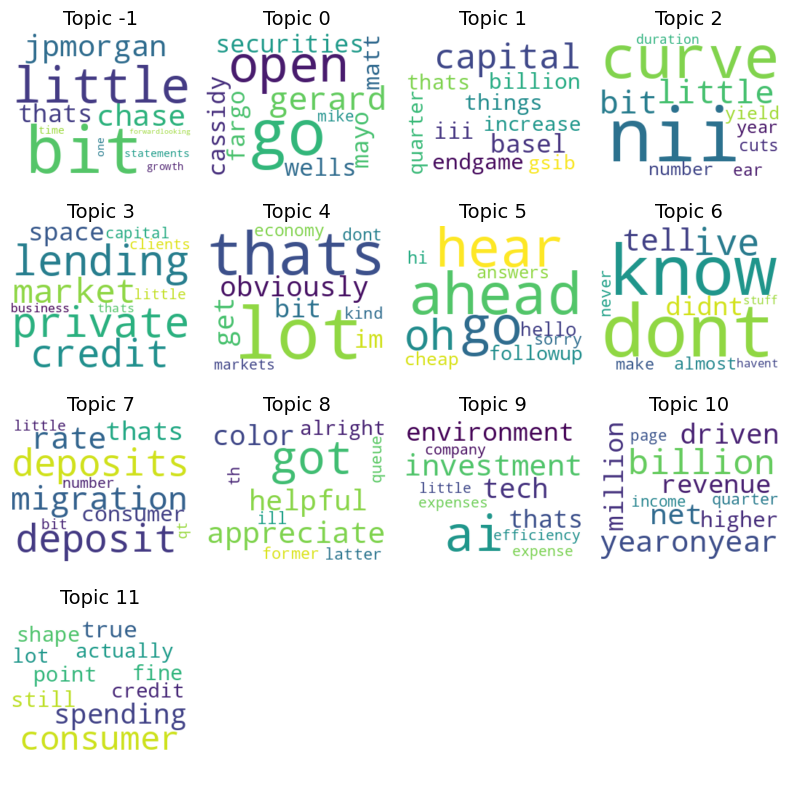

In [ ]:
# JPM Topic Wordcloud
plot_topic_wordclouds(topic_model, n_words=25, max_topics=13, n_cols=4,
                      title="JP Morgan Word Clouds representation", cmap='viridis')

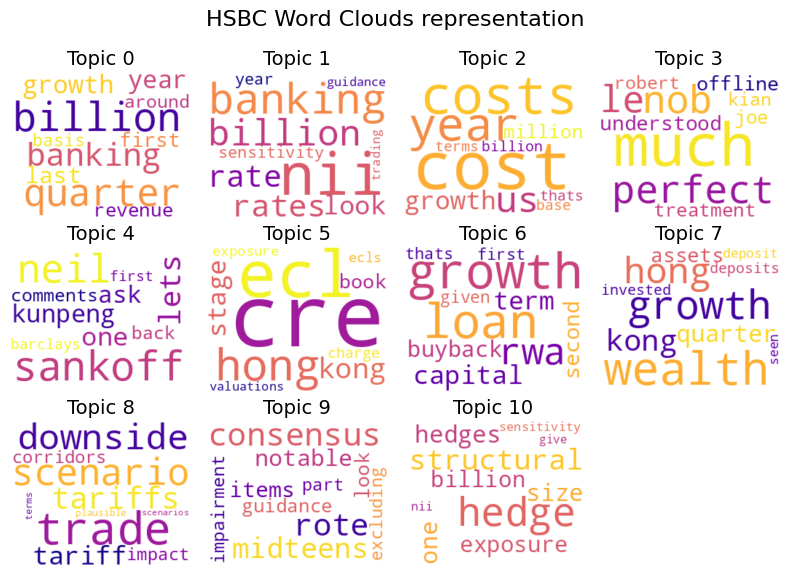

In [252]:
# HSBC Topic Wordcloud
plot_topic_wordclouds(hsbc_topic_model, n_words=25, max_topics=15, n_cols=4,
                      title="HSBC Word Clouds representation", cmap='plasma')

# **5. Trends, Distributions and futher Visualisations**



### PRA Category Trends Over Time


Here we explore the **distributional patterns** of PRA categories. By aggregating theme frequencies over time, we identify which risk areas are gaining or losing prominence across quarterly calls allowing us to transform static topic results into **meaningful business insights**.

In [293]:
jpm_qa_data = jpm_full_23_25[jpm_full_23_25['section'] == 'qa'].copy()
hsbc_qa_data = hsbc_full_23_25[hsbc_full_23_25['section'] == 'qa'].copy()

print("Filtered JPM QA data:")
display(jpm_qa_data.head())

print("\nFiltered HSBC QA data:")
display(hsbc_qa_data.head())

Filtered JPM QA data:


,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,clean_text,Topic,topic_label,pra_category,pra_categories
1,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,so jamie i was actually hoping to get your per...,4,lot / thats / obviously / get / bit / im / eco...,Conduct Risk,"[('Conduct Risk', 0.251), ('Capital Adequacy',..."
2,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,well i think you were already kind of complete...,1,capital / basel / iii / endgame / things / bil...,Capital Adequacy,"[('Capital Adequacy', 0.326), ('Governance', 0..."
3,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,got it and just in terms of appetite for the b...,1,capital / basel / iii / endgame / things / bil...,Capital Adequacy,"[('Capital Adequacy', 0.326), ('Governance', 0..."
4,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,oh yeah,5,ahead / hear / go / oh / followup / hello / ch...,Governance,"[('Governance', 0.281), ('Capital Adequacy', 0..."
5,qa,1.0,2.0,Steven Chubak,analyst,Wolfe Research LLC,...elevated macro uncertainties.,2023,Q1,elevated macro uncertainties,4,lot / thats / obviously / get / bit / im / eco...,Conduct Risk,"[('Conduct Risk', 0.251), ('Capital Adequacy',..."



Filtered HSBC QA data:


,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,clean_text,Topic,topic_label,pra_category,pra_categories
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,good morning gentlemen congrats on a good set...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,thank you joe so first we are hoping to achie...,0,billion / quarter / banking / growth / year / ...,Capital Adequacy,"[(Capital Adequacy, 0.321), (Governance, 0.284)]"
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,good morning gents thanks very much for takin...,6,growth / loan / rwa / capital / term / buyback...,Capital Adequacy,"[(Capital Adequacy, 0.376), (Liquidity, 0.305)]"
5,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, R aul. So on your first question, R...",2023,Q1,True,thank you r aul so on your first question raul...,6,growth / loan / rwa / capital / term / buyback...,Capital Adequacy,"[(Capital Adequacy, 0.376), (Liquidity, 0.305)]"
6,qa,NaN,2.0,Noel Quinn,management,HSBC,Just one additional comment from me . You’ll n...,2023,Q1,False,just one additional comment from me youll not...,-1,Outliers,Conduct Risk,"[(Conduct Risk, 0.28)]"


In [308]:
# Analyse PRA category distribution over time for JPM Q&A data
jpm_qa_pra_time = jpm_qa_data.groupby(['year', 'quarter', 'pra_category']).size().reset_index(name='count')

print("JPM Q&A PRA Category Distribution Over Time:")
display(jpm_qa_pra_time)

JPM Q&A PRA Category Distribution Over Time:


,year,quarter,pra_category,count
0,2023,Q1,Capital Adequacy,27
1,2023,Q1,Conduct Risk,7
2,2023,Q1,Governance,45
3,2023,Q1,Unmapped,6
4,2023,Q2,Capital Adequacy,38
5,2023,Q2,Conduct Risk,9
6,2023,Q2,Governance,35
7,2023,Q2,Unmapped,7
8,2023,Q3,Capital Adequacy,26
9,2023,Q3,Conduct Risk,11


In [322]:
# Visualise PRA category trends over time for JPM Q&A data
fig_jpm = px.line(jpm_qa_pra_time,
                  x='quarter',
                  y='count',
                  color='pra_category',
                  facet_col='year',
                  title='JPM Q&A PRA Category Trends Over Time',
                  labels={'quarter': 'Quarter', 'count': 'Number of Mentions', 'pra_category': 'PRA Category'})

fig_jpm.update_layout(
    title_text='JPM Q&A PRA Category Trends Over Time',
    font_size=12, # Reduced font size
    margin=dict(l=20, r=20, t=40, b=20), # Reduced margins
    width=700, # Wider plot
    height=350 # Reduced height
)

fig_jpm.update_xaxes(categoryorder='array', categoryarray=['Q1', 'Q2', 'Q3', 'Q4'])
fig_jpm.show()

In [301]:
# PRA category distribution over time for HSBC Q&A data
hsbc_qa_pra_time = hsbc_qa_data.groupby(['year', 'quarter', 'pra_category']).size().reset_index(name='count')

print("HSBC Q&A PRA Category Distribution Over Time:")
display(hsbc_qa_pra_time)

HSBC Q&A PRA Category Distribution Over Time:


,year,quarter,pra_category,count
0,2023,Q1,Capital Adequacy,14
1,2023,Q1,Conduct Risk,19
2,2023,Q1,Liquidity,3
3,2023,Q1,Unmapped,3
4,2023,Q2,Capital Adequacy,4
5,2023,Q2,Conduct Risk,25
6,2023,Q2,Liquidity,6
7,2023,Q2,Unmapped,4
8,2023,Q3,Capital Adequacy,3
9,2023,Q3,Conduct Risk,13


In [323]:
# PRA category trends over time for HSBC Q&A data
fig_hsbc = px.line(hsbc_qa_pra_time,
                   x='quarter',
                   y='count',
                   color='pra_category',
                   facet_col='year',
                   title='HSBC Q&A PRA Category Trends Over Time',
                   labels={'quarter': 'Quarter', 'count': 'Number of Mentions', 'pra_category': 'PRA Category'})

fig_hsbc.update_layout(
    title_text='HSBC Q&A PRA Category Trends Over Time',
    font_size=12, # Reduced font size
    margin=dict(l=20, r=20, t=40, b=20), # Reduced margins
    width=700, # Wider plot
    height=350 # Reduced height
)

fig_hsbc.update_xaxes(categoryorder='array', categoryarray=['Q1', 'Q2', 'Q3', 'Q4'])
fig_hsbc.show()

### Topic Distribution in Q&A

We perform additional, varied exploration to gain a different perspective on our findings.

In [291]:
# Analyse topic distribution in JPM Q&A data
jpm_qa_topic_counts = jpm_qa_data['topic_label'].value_counts().reset_index()
jpm_qa_topic_counts.columns = ['topic_label', 'count']

print("JPM Q&A Topic Distribution:")
display(jpm_qa_topic_counts)

JPM Q&A Topic Distribution:


,topic_label,count
0,Outliers,240
1,go / open / gerard / securities / cassidy / fa...,82
2,capital / basel / iii / endgame / things / bil...,71
3,nii / curve / little / bit / yield / number / ...,53
4,lending / private / credit / market / space / ...,53
5,lot / thats / obviously / get / bit / im / eco...,51
6,ahead / hear / go / oh / followup / hello / ch...,48
7,dont / know / ive / tell / didnt / almost / ma...,46
8,deposit / deposits / migration / rate / thats ...,43
9,got / appreciate / helpful / color / alright /...,30


In [292]:
# Visualise topic distribution for JPM Q&A (excluding Outliers)
jpm_qa_topic_viz_data = jpm_qa_topic_counts[jpm_qa_topic_counts['topic_label'] != 'Outliers']

fig = px.bar(jpm_qa_topic_viz_data,
             x='topic_label',
             y='count',
             title='Distribution of BERTopic Topics in JPM Analyst Q&A (Excluding Outliers)',
             labels={'topic_label': 'Topic Label', 'count': 'Number of Mentions'},
             color='topic_label')

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

In [294]:
# Analyse topic distribution in HSBC Q&A data
hsbc_qa_topic_counts = hsbc_qa_data['topic_label'].value_counts().reset_index()
hsbc_qa_topic_counts.columns = ['topic_label', 'count']

print("HSBC Q&A Topic Distribution:")
display(hsbc_qa_topic_counts)

HSBC Q&A Topic Distribution:


,topic_label,count
0,Outliers,138
1,nii / banking / billion / rates / rate / look ...,33
2,cost / costs / year / us / growth / million / ...,29
3,much / nob / perfect / le / understood / offli...,23
4,billion / quarter / banking / growth / year / ...,21
5,sankoff / neil / lets / one / kunpeng / ask / ...,21
6,cre / ecl / hong / kong / stage / book / charg...,20
7,growth / loan / rwa / capital / term / buyback...,16
8,wealth / growth / hong / kong / quarter / asse...,14
9,trade / scenario / downside / tariffs / tariff...,14


In [295]:
# Visualise topic distribution for HSBC Q&A (excluding Outliers)
hsbc_qa_topic_viz_data = hsbc_qa_topic_counts[hsbc_qa_topic_counts['topic_label'] != 'Outliers']

fig = px.bar(hsbc_qa_topic_viz_data,
             x='topic_label',
             y='count',
             title='Distribution of BERTopic Topics in HSBC Analyst Q&A (Excluding Outliers)',
             labels={'topic_label': 'Topic Label', 'count': 'Number of Mentions'},
             color='topic_label')

fig.update_layout(xaxis={'categoryorder':'total descending'})
fig.show()

### Topic to PRA Sankey flowcharts

We create a combined flowchart incorporating topics from both banks for better visual representation.

In [347]:
# @title
# Combine and label your data
hsbc_full_23_25['bank'] = 'HSBC'
jpm_full_23_25['bank'] = 'JPM'
combined_df = pd.concat([hsbc_full_23_25, jpm_full_23_25], ignore_index=True)

# Filter out Outliers before grouping
combined_df = combined_df[combined_df['topic_label'] != 'Outliers'].copy()

# Group and count
flow_counts = combined_df.groupby(['bank', 'topic_label', 'pra_category']).size().reset_index(name='count')

# Build node labels
hsbc_topics = flow_counts[flow_counts['bank'] == 'HSBC']['topic_label'].unique().tolist()
jpm_topics  = flow_counts[flow_counts['bank'] == 'JPM']['topic_label'].unique().tolist()
pra_cats    = sorted(flow_counts['pra_category'].unique().tolist()) # Sorted PRA categories for consistent middle positioning

all_nodes = hsbc_topics + pra_cats + jpm_topics

# Map nodes to indices
node_index = {label: i for i, label in enumerate(all_nodes)}

# Source and target indices
source = []
target = []
value  = []

for _, row in flow_counts.iterrows():
    topic = row['topic_label']
    pra = row['pra_category']
    if row['bank'] == 'HSBC':
        source.append(node_index[topic])
        target.append(node_index[pra])
    else:  # JPM
        source.append(node_index[topic])
        target.append(node_index[pra])
    value.append(row['count'])

# Assign x positions manually (JPM on left, PRA middle, HSBC on right)
x = []
for node in all_nodes:
    if node in jpm_topics:
        x.append(0.0)   # JPM → left
    elif node in pra_cats:
        x.append(0.5)   # PRA → center
    else:  # HSBC
        x.append(1.0)   # HSBC → right


# Dummy y values (you can just space them evenly)
y = [i / len(all_nodes) for i in range(len(all_nodes))]


###
# Node colours
###
# Define custom colors
hsbc_color = 'rgba(220, 20, 60, 0.8)'     # Crimson red
jpm_color  = 'rgba(70, 130, 180, 0.8)'    # Steel blue
pra_color  = 'rgba(160, 160, 160, 0.8)'   # Neutral gray

# Assign colors per node based on category
node_colors = []
for node in all_nodes:
    if node in hsbc_topics:
        node_colors.append(hsbc_color)
    elif node in jpm_topics:
        node_colors.append(jpm_color)
    else:  # PRA categories
        node_colors.append(pra_color)

# Create Sankey
fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=20,
        thickness=30,
        label=all_nodes,
        x=x,
        y=y,
         color='rgba(100, 149, 237, 0.8)' # transparent blue
    ),
    link=dict(
        source=source,
        target=target,
        value=value,
        color='rgba(100, 149, 237, 0.4)'  #transparent blue
    )
)])

fig.update_layout(title_text="Combined JPM (left) & HSBC (right) Topics → PRA Categories", font_size=15, width=1700, height=700)
fig.show()

In [364]:
#Coloured Sankey diagram - Combined JP Morgan & HSBC data (using a custom function)

def plot_combined_sankey(hsbc_df, jpm_df, title="Combined Sankey: JPM & HSBC → PRA Categories"):
    # Add source identifiers
    hsbc_df = hsbc_df.copy()
    jpm_df = jpm_df.copy()
    hsbc_df['bank'] = 'HSBC'
    jpm_df['bank'] = 'JPM'

    # Combine data
    combined_df = pd.concat([hsbc_df, jpm_df], ignore_index=True)

    # Remove "Outliers"
    combined_df = combined_df[combined_df['topic_label'] != 'Outliers'].copy()

    # === Truncate topic labels: "Topic N: first 5 words..." ===
    def extract_topic_number_and_trim(label):
        parts = label.split(':')
        topic_num = parts[0].strip()
        topic_text = parts[1] if len(parts) > 1 else ''
        trimmed_text = ' '.join(topic_text.strip().split()[:5])
        return f"{topic_num}: {trimmed_text}..." if trimmed_text else topic_num

    combined_df['short_topic_label'] = combined_df['topic_label'].apply(extract_topic_number_and_trim)

    # Group and count flows
    flow_counts = combined_df.groupby(['bank', 'short_topic_label', 'pra_category']).size().reset_index(name='count')

    # Remove topic names that overlap with PRA categories (prevents misplacement)
    pra_cats = sorted(flow_counts['pra_category'].unique().tolist())
    flow_counts = flow_counts[~flow_counts['short_topic_label'].isin(pra_cats)]

    # Define node groups
    hsbc_topics = flow_counts[flow_counts['bank'] == 'HSBC']['short_topic_label'].unique().tolist()
    jpm_topics  = flow_counts[flow_counts['bank'] == 'JPM']['short_topic_label'].unique().tolist()

    all_nodes = jpm_topics + pra_cats + hsbc_topics
    node_index = {label: i for i, label in enumerate(all_nodes)}

    # Map sources and targets
    source, target, value = [], [], []
    for _, row in flow_counts.iterrows():
        topic = row['short_topic_label']
        pra = row['pra_category']
        source.append(node_index[topic])
        target.append(node_index[pra])
        value.append(row['count'])

    # Assign manual x positions
    x = []
    for node in all_nodes:
        if node in jpm_topics:
            x.append(0.0)
        elif node in pra_cats:
            x.append(0.5)
        else:  # HSBC
            x.append(1.0)

    # Evenly spaced y positions
    y = [i / len(all_nodes) for i in range(len(all_nodes))]

    # Assign node colors
    hsbc_color = 'rgba(178, 34, 34, 0.5)'      # Dark red
    jpm_color  = 'rgba(25, 91, 113, 0.5)'      # Cadet blue
    pra_color  = 'rgba(128, 128, 128, 0.5)'    # Grey

    node_colors = []
    for node in all_nodes:
        if node in hsbc_topics:
            node_colors.append(hsbc_color)
        elif node in jpm_topics:
            node_colors.append(jpm_color)
        else:
            node_colors.append(pra_color)

    # Link colors inherit from source node
    link_colors = [node_colors[source[i]] for i in range(len(source))]

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        arrangement='snap',
        node=dict(
            pad=20,
            thickness=30,
            label=all_nodes,
            color=node_colors,
            x=x,
            y=y,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    fig.update_layout(
        title_text=title,
        font_size=16,
        width=1700,
        height=700,
        plot_bgcolor='white'
    )

    fig.show()


In [365]:
plot_combined_sankey(hsbc_full_23_25, jpm_full_23_25)

In [376]:
###
#Coloured Sankey diagram - Combined JP Morgan & HSBC data (using a custom function - Shows Only Topic ID)
###

def plot_combined_sankey(hsbc_df, jpm_df, title="Combined Sankey: JPM & HSBC → PRA Categories"):
    # Add bank identifiers
    hsbc_df = hsbc_df.copy()
    jpm_df = jpm_df.copy()
    hsbc_df['bank'] = 'HSBC'
    jpm_df['bank'] = 'JPM'

    # Combine data
    combined_df = pd.concat([hsbc_df, jpm_df], ignore_index=True)

    # Remove Outliers
    combined_df = combined_df[combined_df['topic_label'] != 'Outliers'].copy()

    # Use only topic ID from 'Topic' column and tag it with bank
    combined_df['topic_id'] = combined_df.apply(lambda row: f"{row['bank']} - {row['Topic']}", axis=1)

    # Group and count flows
    flow_counts = combined_df.groupby(['bank', 'topic_id', 'pra_category']).size().reset_index(name='count')

    # Remove topic labels that match PRA categories (just in case)
    pra_cats = sorted(flow_counts['pra_category'].unique().tolist())
    flow_counts = flow_counts[~flow_counts['topic_id'].isin(pra_cats)]

    # Define node groups
    hsbc_topics = flow_counts[flow_counts['bank'] == 'HSBC']['topic_id'].unique().tolist()
    jpm_topics  = flow_counts[flow_counts['bank'] == 'JPM']['topic_id'].unique().tolist()

    all_nodes = jpm_topics + pra_cats + hsbc_topics
    node_index = {label: i for i, label in enumerate(all_nodes)}

    # Map sources and targets
    source, target, value = [], [], []
    for _, row in flow_counts.iterrows():
        topic = row['topic_id']
        pra = row['pra_category']
        source.append(node_index[topic])
        target.append(node_index[pra])
        value.append(row['count']) # more defined links * 2, 3, 5

    # Assign manual x positions
    x = []
    for node in all_nodes:
        if node in jpm_topics:
            x.append(0.0)
        elif node in pra_cats:
            x.append(0.5)
        else:  # HSBC
            x.append(1.0)

    # Evenly spaced y positions
    y = [i / len(all_nodes) for i in range(len(all_nodes))]

    # Assign node colors
    hsbc_color = 'rgba(178, 34, 34, 0.5)'      # Dark red
    jpm_color  = 'rgba(25, 91, 113, 0.5)'      # Cadel blue
    pra_color  = 'rgba(128, 128, 128, 0.5)'    # Grey

    node_colors = []
    for node in all_nodes:
        if node in hsbc_topics:
            node_colors.append(hsbc_color)
        elif node in jpm_topics:
            node_colors.append(jpm_color)
        else:
            node_colors.append(pra_color)

    # Link colors inherit from source node
    link_colors = [node_colors[source[i]] for i in range(len(source))]

    # Create Sankey diagram
    fig = go.Figure(data=[go.Sankey(
        arrangement='snap',
        node=dict(
            pad=20,
            thickness=30,
            label=all_nodes,
            color=node_colors,
            x=x,
            y=y,
        ),
        link=dict(
            source=source,
            target=target,
            value=value,
            color=link_colors
        )
    )])

    fig.update_layout(
        title_text=title,
        font_size=20,
        width=1700,
        height=700,
        plot_bgcolor='white'
    )

    fig.show()


In [371]:
plot_combined_sankey(hsbc_full_23_25, jpm_full_23_25)

Static image of the graph above for cleaner spread of topics.

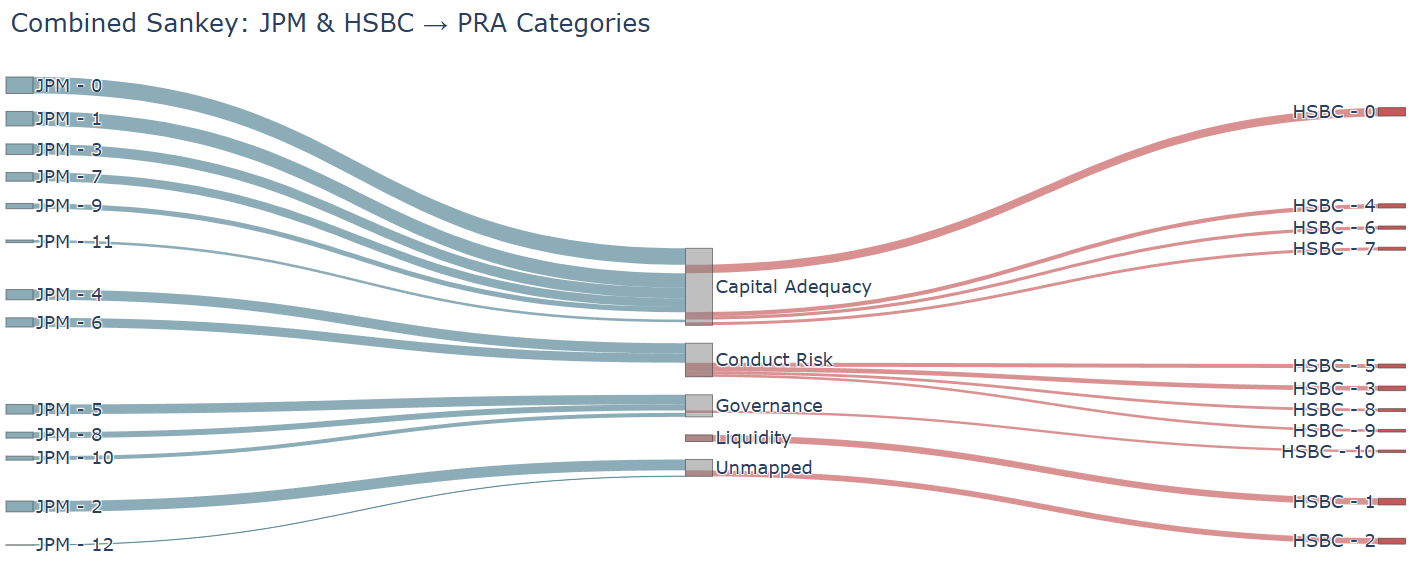

# **6. LDA Analysis**

We explore a traditional topic modelling approach **Latent Dirichlet Allocation (LDA)** to validate BERTopic’s interpretability.
\
While LDA relies on bag-of-words and probabilistic word co-occurrence, comparing its results against transformer-based BERTopic illustrates the improvement in semantic precision achieved through contextual embeddings.


In [103]:
# Preprocessing with NLTK - For tokenisation

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Stop words
stop_words = set(stopwords.words('english'))
tokenised_stop_words = (list(stop_words) + custom_stop_words)

# Clean punctuation, numbers, make lower case, tokenise and clean stopwords function
def tokenize_text(text):
  if not isinstance(text, str):
    return [] # Return empty list or handle non-string input as appropriate
  text = text.lower() # lowercase letters
  text = re.sub(f'[{re.escape(string.punctuation)}\u2019\u2018]', '', text) # removes punctuation including curly quotes
  text = re.sub(r'\d+', '', text) # removes numbers
  # text = re.sub(r'[^\w\d\s\']+', '', text)
  words = word_tokenize(text) # tokenizes words
  words = [word for word in words if word not in tokenised_stop_words] # removes stopwords
  return words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


### JP Morgan

In [104]:
# Add the tokenized data column in the dataframe
jpm_full_23_25['tokens'] = jpm_full_23_25['content'].apply(tokenize_text)
jpm_full_23_25['tokens']

,tokens
0,"[everyone, presentation, available, website, r..."
1,"[actually, hoping, get, perspective, recent, d..."
2,"[already, kind, complete, answering, look, hop..."
3,"[got, terms, appetite, buyback, given]"
4,[oh]
...,...
787,"[go, seriously]"
788,"[say, one, looked, insights, us, let, us, know..."
789,"[anyone, different, opinion, always, intereste..."
790,[]


In [105]:
# Create Dictionary
# Pass the list of token lists directly to the Dictionary constructor
jpm_dictionary = corpora.Dictionary(jpm_full_23_25['tokens'])

# Create corpus (list of bag-of-words)
jpm_corpus = [jpm_dictionary.doc2bow(word) for word in jpm_full_23_25['tokens']]

# Review
print("Number of unique words in dictionary:", len(jpm_dictionary))
print("Number of documents in corpus:", len(jpm_corpus))

Number of unique words in dictionary: 4346
Number of documents in corpus: 792


In [106]:
# Instantiate the LDA model with 10 topics
jpm_lda_model = LdaModel(corpus=jpm_corpus,
                     id2word=jpm_dictionary,
                     num_topics=10, # 12, 18
                     random_state=100, # for reproducibility
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

print("JP Morgan LDA model training complete.")

JP Morgan LDA model training complete.


In [107]:
# Print the topics
jpm_lda_model.print_topics()

[(0,
  '0.060*"go" + 0.027*"john" + 0.025*"gerard" + 0.025*"ahead" + 0.020*"stanley" + 0.020*"cassidy" + 0.016*"sorry" + 0.015*"graseck" + 0.013*"rbc" + 0.012*"research"'),
 (1,
  '0.020*"–" + 0.017*"rate" + 0.015*"got" + 0.014*"nii" + 0.014*"curve" + 0.014*"rates" + 0.012*"deposits" + 0.011*"us" + 0.011*"youve" + 0.011*"fed"'),
 (2,
  '0.021*"thats" + 0.014*"know" + 0.012*"weve" + 0.012*"things" + 0.012*"obviously" + 0.012*"dont" + 0.012*"little" + 0.012*"bit" + 0.011*"time" + 0.011*"point"'),
 (3,
  '0.023*"growth" + 0.023*"bit" + 0.020*"little" + 0.012*"year" + 0.012*"seeing" + 0.011*"sort" + 0.009*"loan" + 0.009*"terms" + 0.009*"lower" + 0.008*"consumer"'),
 (4,
  '0.046*"chase" + 0.045*"jpmorgan" + 0.034*"statements" + 0.027*"cos" + 0.027*"forwardlooking" + 0.021*"securities" + 0.019*"return" + 0.016*"co" + 0.016*"results" + 0.015*"actual"'),
 (5,
  '0.039*"capital" + 0.020*"business" + 0.017*"company" + 0.013*"clients" + 0.013*"risk" + 0.010*"markets" + 0.010*"market" + 0.010*"go

In [108]:
# Visualise the Distance map
pyLDAvis.enable_notebook()
jpm_topic_graph = gensimvis.prepare(jpm_lda_model, jpm_corpus, jpm_dictionary)
pyLDAvis.display(jpm_topic_graph)

The majority of words in TOPIC 1 are still filler words with little value...


### HSBC

In [112]:
hsbc_full_23_25['tokens'] = hsbc_full_23_25['content'].apply(tokenize_text)
hsbc_full_23_25['tokens']

,tokens
0,"[richard, london, hong, kong, joining, first, ..."
1,"[noel, warm, us, call, today, let, begin, firs..."
2,"[gentlemen, congrats, set, numbers, wasnt, eas..."
3,"[joe, first, hoping, achieve, billion, three, ..."
4,"[gents, follow, capital, return, firstly, ive,..."
...,...
371,"[make, comment, fx, course, theres, transactio..."
372,"[three, first, want, ask, outstanding, parts, ..."
373,"[let, third, ill, ask, pam, address, first, tw..."
374,"[billion, threshold, deductions, thats, slide,..."


In [ ]:
# Setup a corpus, dictionary & model
hsbc_dictionary = corpora.Dictionary(hsbc_full_23_25['tokens'])
hsbc_corpus = [hsbc_dictionary.doc2bow(word) for word in hsbc_full_23_25['tokens']]

print("Number of unique words in dictionary:", len(hsbc_dictionary))
print("Number of documents in corpus:", len(hsbc_corpus))

Number of unique words in dictionary: 4500
Number of documents in corpus: 376


In [ ]:
# Instantiate the LDA model with 10 topics
hsbc_lda_model = LdaModel(corpus=hsbc_corpus,
                     id2word=hsbc_dictionary,
                     num_topics=12, # 18
                     random_state=100, # for reproducibility
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

print("HSBC LDA model training complete.")

HSBC LDA model training complete.


In [ ]:
hsbc_lda_model.print_topics()

[(0,
  '0.010*"fall" + 0.008*"funds" + 0.006*"land" + 0.003*"lean" + 0.002*"wrote" + 0.002*"pencilled" + 0.002*"runs" + 0.002*"majors" + 0.002*"pays" + 0.002*"busy"'),
 (1,
  '0.020*"business" + 0.016*"strategy" + 0.016*"years" + 0.014*"opportunity" + 0.011*"weve" + 0.011*"invest" + 0.010*"international" + 0.010*"team" + 0.009*"dividend" + 0.008*"five"'),
 (2,
  '0.089*"scenario" + 0.073*"downside" + 0.038*"plausible" + 0.027*"ecl" + 0.025*"ecls" + 0.013*"cre" + 0.013*"tariff" + 0.012*"adverse" + 0.010*"thoughts" + 0.010*"correction"'),
 (3,
  '0.004*"bay" + 0.004*"lcr" + 0.004*"twoyear" + 0.003*"province" + 0.003*"guangdong" + 0.002*"bounce" + 0.002*"erm" + 0.002*"tomid" + 0.002*"depos" + 0.002*"conversation"'),
 (4,
  '0.045*"nii" + 0.041*"billion" + 0.030*"hedge" + 0.027*"structural" + 0.023*"sensitivity" + 0.020*"banking" + 0.019*"bocom" + 0.017*"cet" + 0.013*"impairment" + 0.012*"value"'),
 (5,
  '0.030*"bit" + 0.021*"little" + 0.020*"thinking" + 0.017*"pretty" + 0.012*"pl" + 0.01

In [ ]:
# Print Topic distance
pyLDAvis.enable_notebook()
hsbc_topic_graph = gensimvis.prepare(hsbc_lda_model, hsbc_corpus, hsbc_dictionary)
pyLDAvis.display(hsbc_topic_graph)

# **7. Conclusion & Key Findings**

This notebook presented an end-to-end workflow for **topic modelling of bank earnings call transcripts**, aligned to **PRA risk categories**. Using transformer-based embeddings and BERTopic, we extracted semantically rich themes from unstructured text, and then linked them to supervisory domains for interpretability.


### Summary of Technical Approach
- **Embedding-Based Topic Modelling**: Applied BERTopic with domain-tuned embeddings to generate high-coherence topics reflecting financial themes.  
- **Topic Interpretation**: Refined topic labels using top terms, enabling intuitive understanding of each cluster’s semantic meaning.  
- **Regulatory Alignment**: Mapped extracted topics to **PRA risk categories** using embedding similarity, bridging results to structured risk taxonomies.  
- **Visual Analytics**: Developed Sankey diagrams, word clouds, and trend plots to visualise how thematic discussions flow into regulatory priorities and evolve over time.


### Key Analytical Insights
1. **Dominant Risk Themes**  
   - Topics related to *capital adequacy, liquidity management, and credit quality* appeared most frequently across earnings calls.  
   - This indicates a consistent supervisory and investor focus on balance sheet resilience and regulatory compliance.

2. **Bank-Specific Focus Areas**  
   - **JP Morgan** discussions showed strong emphasis on *capital ratios, regulatory buffers, and market outlook*.  
   - **HSBC** exhibited greater thematic density around *operational restructuring, digital transformation, and regional liquidity trends*.

3. **Temporal Trends**  
   - The prominence of *credit and capital topics* fluctuated with macroeconomic uncertainty (e.g., interest rate changes, loan performance).  
   - *Operational and governance topics* have gradually increased, reflecting supervisory attention to non-financial risks.

4. **Model Comparison**  
   - BERTopic outperformed classical LDA in capturing nuanced financial language and producing semantically coherent topics.  
   - Embedding-based matching enabled a direct mapping to regulatory risk categories, improving interpretability for stakeholders.


### Implications
This workflow demonstrates that transformer-based topic modelling can serve as a **scalable text analytics framework** for regulatory insight generation.  
By aligning model outputs with PRA categories, the analysis bridges the gap between **qualitative disclosures** and **quantitative risk supervision**, supporting more proactive oversight and thematic intelligence.

---
\
**Next Steps**
- Extend the analysis to additional banks for cross-institutional comparison.  
- Automate PRA category mapping for continuous ingestion of new transcripts.
- Integrate sentiment analysis to assess tone and forward-looking risk sentiment.  
- Devise a system to identify evasive answers and generate a shortlist of flagged disclosures.
- Aggregate the above results into concise, regulator-ready summaries.

Together, these enhancements would further evolve the model into a production-grade regulatory intelligence tool.


# **8. Model Experimentation & Comparison (Appendix)**


This appendix documents additional data exploration, alternative embedding models, hyperparameter tuning, and clustering strategies.  
It serves as a technical audit trail, ensuring reproducibility and transparency of modelling choices (e.g., embedding dimension, UMAP parameters, minimum cluster size).




In [ ]:
#Import necessary Libraries
import pandas as pd
import re
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk import FreqDist
import spacy
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load JPMorgan transcripts from 2023–2025 and preview the first few rows.
df = pd.read_csv("/all_jpm_2023_2025.csv")
df.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
1,qa,NaN,NaN,Steven Chubak,analyst,Wolfe Research LLC,"Hey, good morning.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
2,qa,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorgan Chase & Co.,"Good morning, Steve.",2023,Q1,True,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


Filtering pleasantries

In [ ]:
#Filter out pleasantries and small talk to to improve topic modelling and reduce noise.
df_filtered = df[df['is_pleasantry'] == False].copy()
df_filtered.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Jeremy Barnum,Chief Financial Officer,JPMorganChase,"Thanks, and good morning, everyone. The presen...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
3,qa,1.0,NaN,Steven Chubak,analyst,Wolfe Research LLC,"So, Jamie, I was actually hoping to get your p...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
4,qa,1.0,1.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Well, I think you were already kind of complet...",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
5,qa,1.0,1.0,Steven Chubak,analyst,Wolfe Research LLC,Got it. And just in terms of appetite for the ...,2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...
6,qa,1.0,2.0,Jamie Dimon,Chairman & Chief Executive Officer,JPMorgan Chase & Co.,"Oh, yeah.",2023,Q1,False,data/raw/jpm/.ipynb_checkpoints/jpm-1q23-earni...


Handling missing content

In [ ]:
# Replace missing content with empty strings and remove blank entries.
df_filtered['content'] = df_filtered['content'].fillna('')
df_filtered = df_filtered[df_filtered['content'].str.strip() != '']

In [ ]:
#  Reset index after filtering to ensure clean, sequential row labels.
df_filtered.reset_index(drop=True, inplace=True)

In [ ]:
# Display the number of cleaned transcripts and preview key  columns.
print(f"Cleaned transcript count: {len(df_filtered)}")
df_filtered[['quarter', 'year', 'speaker_name', 'content']].head()

Cleaned transcript count: 1218


,quarter,year,speaker_name,content
0,Q1,2023,Jeremy Barnum,"Thanks, and good morning, everyone. The presen..."
1,Q1,2023,Steven Chubak,"So, Jamie, I was actually hoping to get your p..."
2,Q1,2023,Jamie Dimon,"Well, I think you were already kind of complet..."
3,Q1,2023,Steven Chubak,Got it. And just in terms of appetite for the ...
4,Q1,2023,Jamie Dimon,"Oh, yeah."


Cleaning and Preprocessing  text data using spacy and regular expression

In [ ]:
# Load spaCy NLP pipeline and Counter for token frequency analysis.

import spacy
from collections import Counter

nlp = spacy.load("en_core_web_sm")
#  Regex-based cleaner to remove numbers and punctuation, and lowercase the text.
def clean_text_regex(text):
    import re

    text = str(text)
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    return text.lower().strip()
# Lemmatize tokens, remove stopwords and custom financial filler terms for cleaner semantic input.

def preprocess_with_spacy(text, custom_stopwords=None):
    if not isinstance(text, str):
        return []
    custom_stopwords = custom_stopwords or set([
        'billion', 'million', 'trillion', 'earnings', 'quarter', 'year', 'revenue',
        'net', 'income', 'share', 'analyst', 'call', 'firm', 'bank', 'banking',
        'financial', 'market', 'stock', 'investor', 'investing', 'credit', 'report',
        'growth', 'guidance', 'expense', 'per', 'cents', 'p', 'loan', 'deposit',
        'margin', 'rate', 'interest', 'federal', 'reserve','think', 'question', 'thing', 'thank', 'capital', 'bit', 'book', 'year', 'right',
    'kind', 'come', 'know', 'obviously', 'talk', 'want', 'point', 'lot', 'actually', 'mean',
    'yeah', 'no', 'yes', 've', 's', 'like', 'see', 'say', 'good', 'start', 'end', 'page'
    ])
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop and token.lemma_ not in custom_stopwords]


# Apply regex cleaning to transcript content to standardize text before NLP processing.

df_filtered['regex_cleaned'] = df_filtered['content'].astype(str).apply(clean_text_regex)

# Tokenize and lemmatize cleaned text using spaCy, excluding stopwords and domain-specific noise.

df_filtered['spacy_tokens'] = df_filtered['regex_cleaned'].apply(preprocess_with_spacy)

# Flatten all tokens for frequency filtering.
all_tokens = [token for tokens in df_filtered['spacy_tokens'] for token in tokens]
token_counts = Counter(all_tokens)

# Minimum and maximum frequency thresholds to filter out rare and overly common tokens.
min_freq = 2
max_freq = len(df_filtered) * 0.8

# Filter tokens based on frequency.
df_filtered['filtered_tokens'] = df_filtered['spacy_tokens'].apply(
    lambda tokens: [token for token in tokens if min_freq <= token_counts[token] <= max_freq]
)

# Convert filtered token lists back into strings for embedding and clustering.
df_filtered['filtered_string'] = df_filtered['filtered_tokens'].apply(lambda x: ' '.join(x))

# Display summary statistics of token counts per document after filtering.
print("Token count stats:")
print(df_filtered['filtered_tokens'].apply(len).describe())

Token count stats:
count    1218.000000
mean       35.990148
std        73.631519
min         0.000000
25%         7.000000
50%        21.000000
75%        42.000000
max       932.000000
Name: filtered_tokens, dtype: float64


/tmp/ipython-input-2659893397.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=token_df.head(30), x='token', y='count', palette='pink')


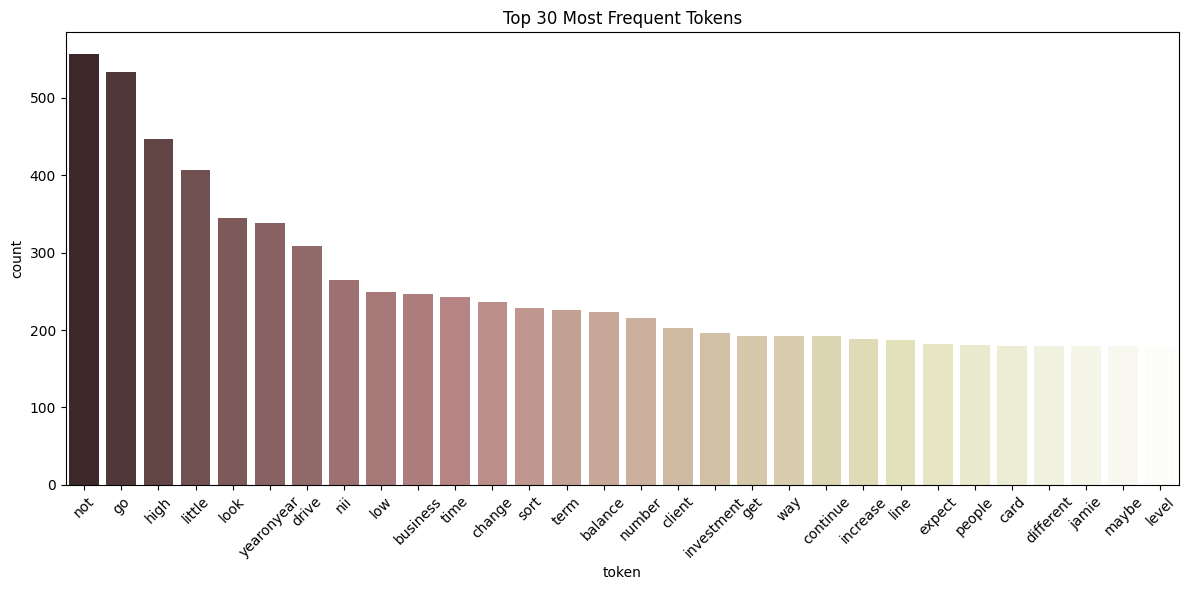

In [ ]:
# Visualize the top 30 most frequent tokens  in the cleaned transcripts.
import matplotlib.pyplot as plt
import seaborn as sns

token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=token_df.head(30), x='token', y='count', palette='pink')
plt.xticks(rotation=45)
plt.title("Top 30 Most Frequent Tokens")
plt.tight_layout()
plt.show()


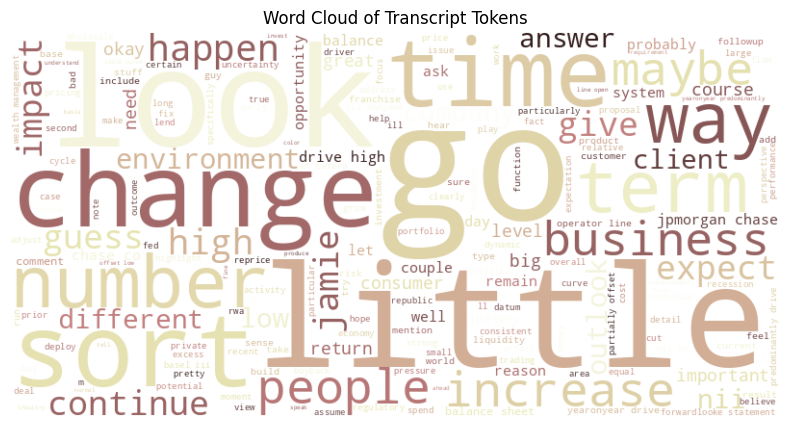

In [ ]:
# Visualize token frequency distribution using a word cloud.
from wordcloud import WordCloud

text_string = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='pink').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcript Tokens")
plt.show()


In [ ]:
from collections import Counter

# Flatten all tokens before filtering.
tokens_before = [token for tokens in df_filtered['spacy_tokens'] for token in tokens]
freq_before = Counter(tokens_before)
df_freq_before = pd.DataFrame(freq_before.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
# Analyze top 30 tokens after frequency filtering.
tokens_after = [token for tokens in df_filtered['filtered_tokens'] for token in tokens]
freq_after = Counter(tokens_after)
df_freq_after = pd.DataFrame(freq_after.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
# Compare total token counts before and after frequency filtering to evaluate how much noise was removed.
filtered_tokens_flat = [token for tokens in df_filtered['filtered_tokens'] for token in tokens]
print(f"Total tokens before filtering: {len(all_tokens)}")
print(f"Total tokens after filtering: {len(filtered_tokens_flat)}")

Total tokens before filtering: 44379
Total tokens after filtering: 43836


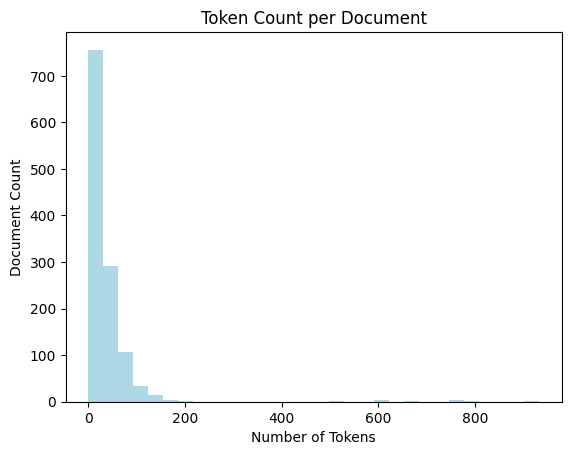

In [ ]:
# Histogram of token count to visualize data distribution.
df_filtered['token_count'] = df_filtered['filtered_tokens'].apply(len)
plt.hist(df_filtered['token_count'], bins=30, color='lightblue')
plt.title("Token Count per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Document Count")
plt.show()

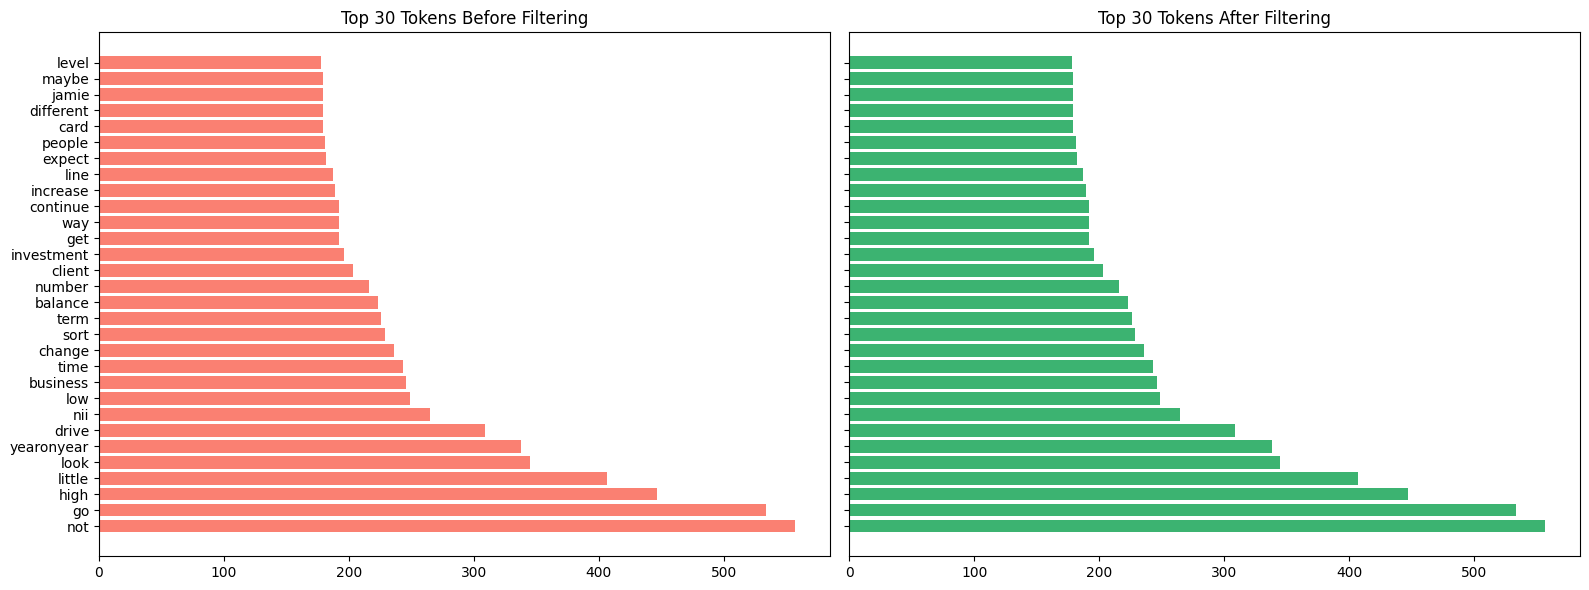

Token count reduced by 1.22% after filtering.


In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Before filtering
axes[0].barh(df_freq_before['token'], df_freq_before['count'], color='salmon')
axes[0].set_title('Top 30 Tokens Before Filtering')
axes[0].invert_yaxis()

# After filtering
axes[1].barh(df_freq_after['token'], df_freq_after['count'], color='mediumseagreen')
axes[1].set_title('Top 30 Tokens After Filtering')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()
# Token Reduction Summary
reduction = 100 * (1 - len(tokens_after) / len(tokens_before))
print(f"Token count reduced by {reduction:.2f}% after filtering.")

In [ ]:
reduction = 100 * (1 - len(tokens_after) / len(tokens_before))
print(f"Token count reduced by {reduction:.2f}% after filtering.")


Token count reduced by 1.22% after filtering.


## Bert topic - JP Morgan




In [ ]:
#  # Import BERTopic, SentenceTransformer, and HDBSCAN for topic modeling and clustering.

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

# Load embedding model to generate semantic representations of transcript text.
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# clustering to capture niche topics.
custom_cluster = HDBSCAN(min_cluster_size=2, min_samples=1)

# Extract cleaned and filtered transcript strings for topic modeling input.
texts = df_filtered['filtered_string'].tolist()

#  Initialize and fit BERTopic model
topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
topics, probs = topic_model.fit_transform(texts)

#  Add topic results to  dataframe.
df_filtered['topic'] = topics
df_filtered['topic_prob'] = probs



/usr/local/lib/python3.12/dist-packages/hdbscan/plots.py:448: SyntaxWarning: invalid escape sequence '\l'
  axis.set_ylabel('$\lambda$ value')
/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

 Topic Exploration

In [ ]:
# Preview topic modeling output to assess clustering quality and keyword relevance.
topic_model.get_topic_info().head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,106,-1_overearne_path_direct_definitely,"[overearne, path, direct, definitely, headwind...",[sure matt guess way couple return tend season...
1,0,10,0_yearonyear_drive_largely_inflow,"[yearonyear, drive, largely, inflow, include, ...",[morning presentation available website refer ...
2,1,8,1_najarian_ubs_erika_proceed,"[najarian, ubs, erika, proceed, line, operator...","[get operator line erika najarian ubs proceed,..."
3,2,8,2_unemployment_central_probabilityweight_adverse,"[unemployment, central, probabilityweight, adv...",[m sure jamie view view caution jump conclusio...
4,3,8,3_agreement_country_american_administration,"[agreement, country, american, administration,...",[betsy different okay different global economy...


In [ ]:
# Visualize the top 10 most frequent topics using a bar chart.
topic_model.visualize_barchart(top_n_topics=10)


In [ ]:
# View representative keywords for Topic 1.
topic_model.get_topic(1)

[('najarian', 0.2942880420529612),
 ('ubs', 0.2942880420529612),
 ('erika', 0.17304010842261552),
 ('proceed', 0.09293899723410066),
 ('line', 0.0909052138917778),
 ('operator', 0.07809882371955515),
 ('steve', 0.07250374486073691),
 ('open', 0.03978179537417714),
 ('poonawala', 0.03828888059907609),
 ('ebrahim', 0.03367932449628398)]

In [ ]:
# View representative keywords for Topic 2.
topic_model.get_topic(2)

[('unemployment', 0.040909517846756935),
 ('central', 0.03737064048473928),
 ('probabilityweight', 0.0346300149296835),
 ('adverse', 0.0346300149296835),
 ('weightedaverage', 0.03179799911510858),
 ('echo', 0.028875141548865012),
 ('skew', 0.027047266641259112),
 ('case', 0.026259643978240422),
 ('tightening', 0.02432434804832292),
 ('weight', 0.023257385648447506)]

In [ ]:
# View representative transcripts for Topic 1 to validate clustering and interpret theme.
topic_model.get_representative_docs(1)

['get operator line erika najarian ubs proceed',
 'operator line erika najarian ubs proceed',
 'operator line erika najarian ubs proceed']

In [ ]:
from sentence_transformers import SentenceTransformer

# Load FinBERT embeddings
embedding_model = SentenceTransformer("ProsusAI/finbert")

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
from bertopic import BERTopic
from hdbscan import HDBSCAN

# clustering for niche topics.
custom_cluster = HDBSCAN(min_cluster_size=2, min_samples=1)

# Initialize BERTopic with FinBERT embeddings and custom clustering, then fit to cleaned transcript text.
finbert_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
texts = df_filtered['filtered_string'].tolist()
finbert_topics, finbert_probs = finbert_model.fit_transform(texts)

# Save FinBERT-based topic assignments and probabilities to the DataFrame for analysis.
df_filtered['topic_finbert'] = finbert_topics
df_filtered['topic_finbert_prob'] = finbert_probs




In [ ]:
# Visualize the top 10 FinBERT-based topics to assess their frequency key themes in the dataset.
finbert_model.visualize_barchart(top_n_topics=10)


In [ ]:
#  Import necessary libraries.
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorize cleaned text and fit LDA model to extract 10  topics.
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df_filtered['filtered_string'])

# Fit Lda model to extract 10  topics from the vectorized transcript data.
lda_model = LatentDirichletAllocation(n_components=10, random_state=42)
lda_model.fit(X)

LatentDirichletAllocation(random_state=42)

In [ ]:
# Define function to print the top keywords for each LDA topic.
def display_topics(model, feature_names, no_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}: ", [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])

display_topics(lda_model, vectorizer.get_feature_names_out())

Topic 0:  ['return', 'look', 'change', 'different', 'client', 'guess', 'way', 'business', 'cycle', 'deploy']
Topic 1:  ['little', 'sort', 'term', 'expect', 'outlook', 'level', 'look', 'continue', 'feel', 'environment']
Topic 2:  ['people', 'look', 'time', 'number', 'little', 'consumer', 'comment', 'jeremy', 'term', 'run']
Topic 3:  ['high', 'jamie', 'number', 'curve', 'little', 'change', 'low', 'cut', 'proposal', 'consumer']
Topic 4:  ['jpmorgan', 'chase', 'statement', 'forwardlooke', 'cos', 'risk', 'happen', 'security', 'look', 'time']
Topic 5:  ['little', 'sort', 'environment', 'term', 'number', 'look', 'business', 'balance', 'maybe', 'sense']
Topic 6:  ['yearonyear', 'drive', 'high', 'nii', 'card', 'low', 'continue', 'offset', 'balance', 'include']
Topic 7:  ['line', 'operator', 'proceed', 'open', 'jeremy', 'okay', 'business', 'ahead', 'helpful', 'liquidity']
Topic 8:  ['time', 'look', 'way', 'need', 'important', 'company', 'little', 'new', 'guess', 'stuff']
Topic 9:  ['look', 'morn

In [ ]:
from top2vec import Top2Vec
# Fit Top2Vec to identify topics based on semantic similarity without prior preprocessing.
model_top2vec = Top2Vec(df_filtered['filtered_string'].tolist(), embedding_model='universal-sentence-encoder')

2025-09-15 21:56:16,111 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
2025-09-15 21:56:16,333 - top2vec - INFO - Downloading universal-sentence-encoder model
INFO:top2vec:Downloading universal-sentence-encoder model
2025-09-15 21:56:43,769 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2025-09-15 21:56:45,008 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2025-09-15 21:56:48,330 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2025-09-15 21:56:48,374 - top2vec - INFO - Finding topics
INFO:top2vec:Finding topics


In [ ]:
# Display representative terms for each Top2Vec topic.
topic_words, word_scores, topic_nums = model_top2vec.get_topics()
for i in range(len(topic_words)):
    print(f"Topic {i}: {topic_words[i][:10]}")

Topic 0: ['volatility' 'recession' 'jpmorgan' 'liquidity' 'uncertainty' 'economy'
 'low' 'chase' 'equity' 'risk']
Topic 1: ['operator' 'chase' 'line' 'jeremy' 'continue' 'jpmorgan' 'uncertainty'
 'open' 'jamie' 'outlook']
Topic 2: ['okay' 'great' 'hear' 'well' 'sure' 'pretty' 'way' 'help' 'hi' 'bad']
Topic 3: ['get' 'take' 'go' 'spend' 'give' 'try' 'make' 'pay' 'fix' 'use']
Topic 4: ['jeremy' 'hear' 'morning' 'chase' 'look' 'consumer' 'jamie' 'lending'
 'big' 'hi']
Topic 5: ['ll' 'not' 'way' 'well' 'second' 'guess' 'et' 'ill' 'answer' 'happen']


### Extract Top Keywords from Each Model

BERTopic

In [ ]:
# Create a dictionary mapping each  bert topic ID to its top 10 keywords for quick reference.
bert_topics = topic_model.get_topics()
bert_summary = {i: [word for word, _ in bert_topics[i][:10]] for i in bert_topics.keys()}

Finbert

In [ ]:
# Create a dictionary mapping each  finbert topic ID to its top 10 keywords for quick reference.
finbert_topics = finbert_model.get_topics()
finbert_summary = {i: [word for word, _ in finbert_topics[i][:10]] for i in finbert_topics if i != -1}

LDA

In [ ]:
# Extract top 10 keywords for each of the first 10 LDA topics.
lda_keywords = []
for topic in lda_model.components_[:10]:
    top_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-11:-1]]
    lda_keywords.append(top_words)


Top2Vec

In [ ]:
# Extract top 10 keywords for each of the first 10 top2vec topics.
top2vec_keywords = []
topic_words, _, _ = model_top2vec.get_topics()
for i in range(len(topic_words)):
    top2vec_keywords.append(topic_words[i][:10])

### Comparison Table

In [ ]:
# Number of topics discovered by each model
model_scores = {
    'BERTopic': len(bert_summary),
    'FinBERT': len(finbert_summary),
    'LDA': len(lda_keywords),
    'Top2Vec': len(top2vec_keywords)
}
model_scores

{'BERTopic': 378, 'FinBERT': 383, 'LDA': 10, 'Top2Vec': 6}

In [ ]:
# Create a DataFrame comparing top 10 topics across BERTopic, FinBERT, LDA, and Top2Vec models.

top_n = 10
comparison_rows = []
for i in range(top_n):
    row = {
        'Topic': f'Topic {i}',
        'BERTopic': bert_summary.get(i, []),
        'FinBERT': finbert_summary.get(i, []),
        'LDA': lda_keywords[i] if i < len(lda_keywords) else [],
        'Top2Vec': top2vec_keywords[i] if i < len(top2vec_keywords) else []
    }
    comparison_rows.append(row)

top_topics_df = pd.DataFrame(comparison_rows)

In [ ]:
# View the dataframe
top_topics_df

,Topic,BERTopic,FinBERT,LDA,Top2Vec
0,Topic 0,"[yearonyear, drive, largely, inflow, include, ...","[seriously, get, true, not, , , , , , ]","[return, look, change, different, client, gues...","[volatility, recession, jpmorgan, liquidity, u..."
1,Topic 1,"[najarian, ubs, erika, proceed, line, operator...","[schorr, evercore, isi, glenn, open, operator,...","[little, sort, term, expect, outlook, level, l...","[operator, chase, line, jeremy, continue, jpmo..."
2,Topic 2,"[unemployment, central, probabilityweight, adv...","[plumbing, volatility, volume, struggle, ingre...","[people, look, time, number, little, consumer,...","[okay, great, hear, well, sure, pretty, way, h..."
3,Topic 3,"[agreement, country, american, administration,...","[bog, announcement, suggestion, barely, backlo...","[high, jamie, number, curve, little, change, l...","[get, take, go, spend, give, try, make, pay, f..."
4,Topic 4,"[seek, discretionary, rotation, nice, nondiscr...","[excellent, appreciate, great, okay, answer, j...","[jpmorgan, chase, statement, forwardlooke, cos...","[jeremy, hear, morning, chase, look, consumer,..."
5,Topic 5,"[wish, answer, , , , , , , , ]","[tail, ci, compute, fat, prominently, quartero...","[little, sort, environment, term, number, look...","[ll, not, way, well, second, guess, et, ill, a..."
6,Topic 6,"[steepness, curve, premium, yield, invert, nim...","[separately, avenue, overarch, demandsupply, s...","[yearonyear, drive, high, nii, card, low, cont...",[]
7,Topic 7,"[wells, fargo, mayo, mike, efficiently, procee...","[institution, uninsured, plenty, sea, facto, s...","[line, operator, proceed, open, jeremy, okay, ...",[]
8,Topic 8,"[forwardlooke, cos, statement, chase, commissi...","[complex, harm, expose, natural, advocacy, und...","[time, look, way, need, important, company, li...",[]
9,Topic 9,"[importance, measure, adversarial, panoply, su...","[bleed, unemployment, tighten, vulnerability, ...","[look, morning, maybe, little, jeremy, guess, ...",[]


In [ ]:
# Def a function cosine similarity between two keyword lists to measure overlap between topic models.
def cosine_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2)) if list1 and list2 else 0

In [ ]:
# Match semantically similar topics across FinBERT and BertMPNet by comparing top keywords.
matches = []
for i, finbert_keywords in finbert_summary.items():
    for j, mpnet_keywords in bert_summary.items():
        score = cosine_similarity(finbert_keywords, mpnet_keywords)
        if score > 0.5:  # threshold for semantic similarity
            matches.append((i, j, score))

In [ ]:
# Display semantically aligned topics across models based on keyword overlap.
for match in matches:
    print(f"FinBERT Topic {match[0]} ≈ Bert Topic {match[1]} | Similarity: {match[2]:.2f}")

FinBERT Topic 1 ≈ Bert Topic 230 | Similarity: 0.82
FinBERT Topic 1 ≈ Bert Topic 302 | Similarity: 0.64
FinBERT Topic 1 ≈ Bert Topic 316 | Similarity: 0.55
FinBERT Topic 4 ≈ Bert Topic 157 | Similarity: 0.57
FinBERT Topic 14 ≈ Bert Topic 8 | Similarity: 1.00
FinBERT Topic 14 ≈ Bert Topic 23 | Similarity: 0.82
FinBERT Topic 14 ≈ Bert Topic 136 | Similarity: 0.54
FinBERT Topic 18 ≈ Bert Topic 82 | Similarity: 0.67
FinBERT Topic 18 ≈ Bert Topic 211 | Similarity: 0.54
FinBERT Topic 19 ≈ Bert Topic 31 | Similarity: 0.54
FinBERT Topic 20 ≈ Bert Topic 327 | Similarity: 0.67
FinBERT Topic 22 ≈ Bert Topic 330 | Similarity: 0.60
FinBERT Topic 23 ≈ Bert Topic 135 | Similarity: 1.00
FinBERT Topic 26 ≈ Bert Topic 159 | Similarity: 0.60
FinBERT Topic 27 ≈ Bert Topic 324 | Similarity: 0.54
FinBERT Topic 31 ≈ Bert Topic 247 | Similarity: 0.67
FinBERT Topic 34 ≈ Bert Topic 14 | Similarity: 0.54
FinBERT Topic 36 ≈ Bert Topic 16 | Similarity: 0.54
FinBERT Topic 37 ≈ Bert Topic 121 | Similarity: 0.67
FinB

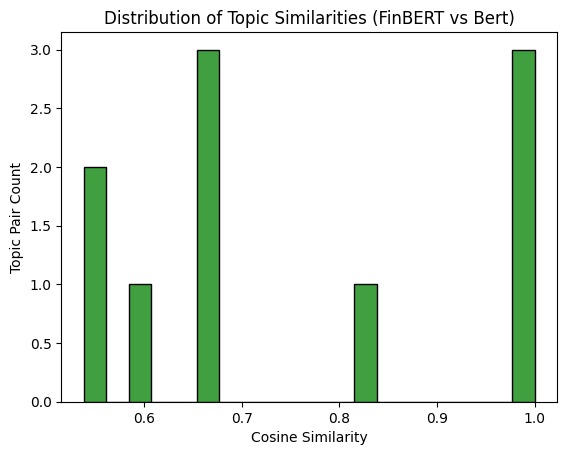

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Plot histogram of cosine similarity scores to assess overlap between FinBERT and BertMPNet topics.

similarities = [match[2] for match in matches]
sns.histplot(similarities, bins=20, color='green')
plt.title("Distribution of Topic Similarities (FinBERT vs Bert)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Topic Pair Count")
plt.show()

### Topic similarity across models
Most topics are the same between the two models suggest by Cosine similarity score of 1, which likely means they’re picking up on common or repeated phrases. But there are also some topics that only partly match, which suggests that FinBERT is better at spotting financial-specific language that BERT sees more generally.


In [ ]:
matched_ids = [match[0] for match in matches if match[2] >= 0.82]
trend_df = df_filtered[df_filtered['topic_finbert'].isin(matched_ids)]
trend_summary = trend_df.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
trend_summary


,year,quarter,topic_finbert,count
0,2023,Q1,48,1
1,2023,Q1,94,1
2,2023,Q1,120,1
3,2023,Q1,152,2
4,2023,Q1,156,1
...,...,...,...,...
136,2025,Q2,357,2
137,2025,Q2,358,2
138,2025,Q2,367,2
139,2025,Q2,373,2


## HSBC


In [ ]:
Hsbc_df=pd.read_csv('/all_hsbc_earnings_data.csv')
Hsbc_df.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
1,presentation,NaN,NaN,Georges Elhedery,Group Chief Executive,HSBC,"Thank you, Noel, and a warm welcome to all of ...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
3,qa,NaN,1.0,Georges Elhedery,management,HSBC,"Thank you, Joe . So first, we are hoping to ac...",2023,Q1,True,230502-1q-2023-hsbc-presentation-to-investors-...
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...


In [ ]:
Hsbc_df= Hsbc_df[Hsbc_df['is_pleasantry'] == False].copy()
Hsbc_df.head()

,section,question_number,answer_number,speaker_name,role,company,content,year,quarter,is_pleasantry,source_pdf
0,presentation,NaN,NaN,Noel Quinn,Group Chief Executive,HSBC,"Thanks, Richard, and good morning in London, g...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
2,qa,1.0,NaN,Joseph Dickerson,Analyst,Jefferies,"Good morning, gentlemen . Congrats on a good s...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
4,qa,2.0,NaN,Raul Sinha,Analyst,JP Morgan,"Good morning, gents . Thanks very much for tak...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
6,qa,NaN,2.0,Noel Quinn,management,HSBC,Just one additional comment from me . You’ll n...,2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...
8,qa,NaN,1.0,Noel Quinn,management,HSBC,"Thanks, Manus. Just on the asset quality of S...",2023,Q1,False,230502-1q-2023-hsbc-presentation-to-investors-...


Handling missing content

In [ ]:
Hsbc_df['content'] = Hsbc_df['content'].fillna('')
Hsbc_df = Hsbc_df[Hsbc_df['content'].str.strip() != '']

In [ ]:
Hsbc_df.reset_index(drop=True, inplace=True)

In [ ]:
#Preview Clean Data
print(f"Cleaned transcript count: {len(Hsbc_df)}")
Hsbc_df[['quarter', 'year', 'speaker_name', 'content']].head()

Cleaned transcript count: 376


,quarter,year,speaker_name,content
0,Q1,2023,Noel Quinn,"Thanks, Richard, and good morning in London, g..."
1,Q1,2023,Georges Elhedery,"Thank you, Noel, and a warm welcome to all of ..."
2,Q1,2023,Joseph Dickerson,"Good morning, gentlemen . Congrats on a good s..."
3,Q1,2023,Georges Elhedery,"Thank you, Joe . So first, we are hoping to ac..."
4,Q1,2023,Raul Sinha,"Good morning, gents . Thanks very much for tak..."


Cleaning and Preprocessing  text data using spacy and regular expression

In [ ]:
# Apply regex cleaning - ensure column is string type first
Hsbc_df['regex_cleaned'] = Hsbc_df['content'].astype(str).apply(clean_text_regex)

# Apply spaCy preprocessing
Hsbc_df['spacy_tokens'] = Hsbc_df['regex_cleaned'].apply(preprocess_with_spacy)

# Flatten all tokens for frequency filtering
all_tokens = [token for tokens in Hsbc_df['spacy_tokens'] for token in tokens]
token_counts = Counter(all_tokens)

# Set frequency thresholds
min_freq = 2
max_freq = len(Hsbc_df) * 0.8

# Filter tokens based on frequency
Hsbc_df['filtered_tokens'] = Hsbc_df['spacy_tokens'].apply(
    lambda tokens: [token for token in tokens if min_freq <= token_counts[token] <= max_freq]
)

# Rejoin tokens into strings for BERTopic input
Hsbc_df['filtered_string'] = Hsbc_df['filtered_tokens'].apply(lambda x: ' '.join(x))

# Optional: inspect token distribution
print("Token count stats:")
print(Hsbc_df['filtered_tokens'].apply(len).describe())

Token count stats:
count    376.000000
mean      78.598404
std      105.618084
min        0.000000
25%       26.000000
50%       53.000000
75%       87.500000
max      852.000000
Name: filtered_tokens, dtype: float64


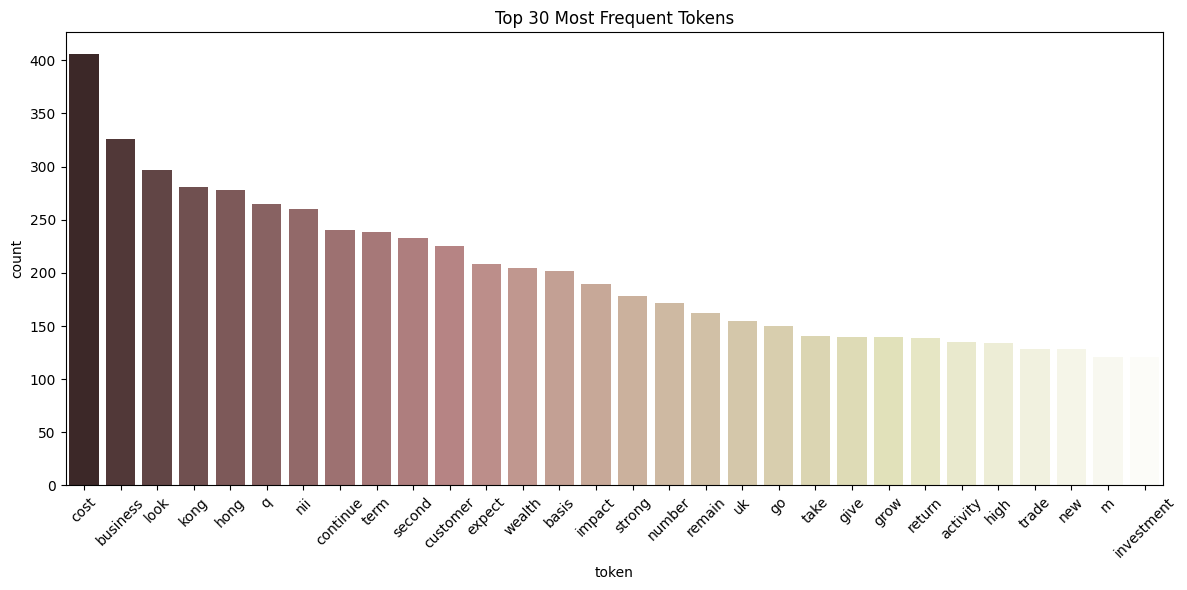

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

token_df = pd.DataFrame(token_counts.items(), columns=['token', 'count']).sort_values(by='count', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=token_df.head(30), x='token', y='count', palette='pink')
plt.xticks(rotation=45)
plt.title("Top 30 Most Frequent Tokens")
plt.tight_layout()
plt.show()


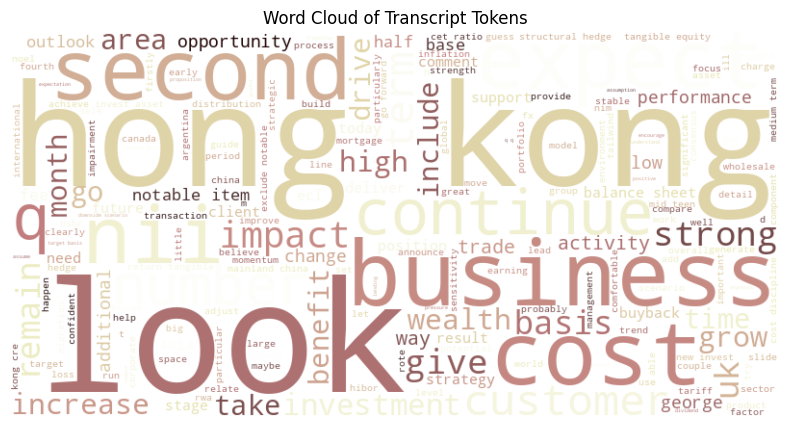

In [ ]:
from wordcloud import WordCloud

text_string = ' '.join(all_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='pink').generate(text_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Transcript Tokens")
plt.show()


In [ ]:
from collections import Counter

# Flatten all tokens before filtering
tokens_before = [token for tokens in Hsbc_df['spacy_tokens'] for token in tokens]
freq_before = Counter(tokens_before)
df_freq_before = pd.DataFrame(freq_before.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
tokens_after = [token for tokens in Hsbc_df['filtered_tokens'] for token in tokens]
freq_after = Counter(tokens_after)
df_freq_after = pd.DataFrame(freq_after.items(), columns=['token', 'count']).sort_values(by='count', ascending=False).head(30)


In [ ]:
filtered_tokens_flat = [token for tokens in Hsbc_df['filtered_tokens'] for token in tokens]
print(f"Total Hsbc tokens before filtering: {len(all_tokens)}")
print(f"Total Hsbc tokens after filtering: {len(filtered_tokens_flat)}")

Total Hsbc tokens before filtering: 31648
Total Hsbc tokens after filtering: 29553


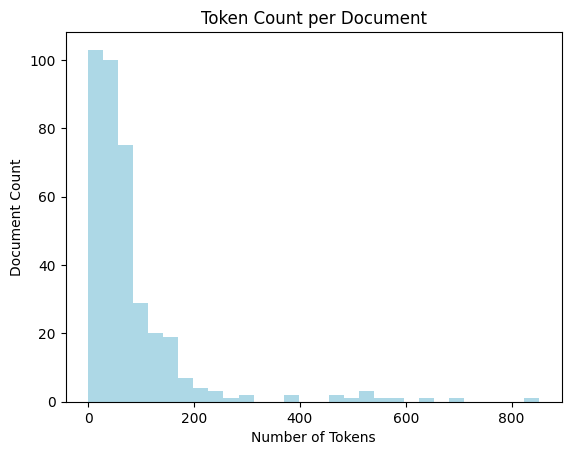

In [ ]:
Hsbc_df['token_count'] = Hsbc_df['filtered_tokens'].apply(len)
plt.hist(Hsbc_df['token_count'], bins=30, color='lightblue')
plt.title("Token Count per Document")
plt.xlabel("Number of Tokens")
plt.ylabel("Document Count")
plt.show()

### Bert Topic

In [ ]:
#  # Import BERTopic, SentenceTransformer, and HDBSCAN for topic modeling and clustering.

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

# Load embedding model to generate semantic representations of transcript text.
embedding_model = SentenceTransformer("all-mpnet-base-v2")

# clustering to capture niche topics.
custom_cluster = HDBSCAN(min_cluster_size=2, min_samples=1)

# Extract cleaned and filtered transcript strings for topic modeling input.
Hsbc_text = Hsbc_df['filtered_string'].tolist()

#  Initialize and fit BERTopic model
Hsbc_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
topics, probs = Hsbc_model.fit_transform(Hsbc_text)

#  Add topic results to  dataframe.
Hsbc_df['topic'] = topics
Hsbc_df['topic_prob'] = probs

In [ ]:
Hsbc_model.visualize_heatmap()

In [ ]:
Hsbc_model.visualize_barchart(top_n_topics=10)

In [ ]:
Hsbc_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,41,-1_look_trade_nii_client,"[look, trade, nii, client, impact, fourth, tar...",[george join fullyear focus discipline way pri...
1,0,15,0_morning_big_noel_wonder,"[morning, big, noel, wonder, street, buyback, ...",[morning l morning george need non perform q a...
2,1,10,1_sankoff_neil_coomb_let,"[sankoff, neil, coomb, let, kunpeng, jeremy, r...","[neil sankoff let andy coomb, neil sankoff let..."
3,2,7,2_sensitivity_structural_hedge_reduction,"[sensitivity, structural, hedge, reduction, up...",[sensitivity downside basis scenario reduce ha...
4,3,6,3_midteen_rote_notable_oneoff,"[midteen, rote, notable, oneoff, understand, a...",[midteen rote target basis ex notable item lin...
5,4,6,4_pam_address_ask_ben,"[pam, address, ask, ben, andrew, remember, go,...",[ben go ask pam address ben remember cet ratio...
6,5,6,5_collateralisation_lending_rwa_portfolio,"[collateralisation, lending, rwa, portfolio, d...",[risk basis encapsulate currently foresee bala...
7,6,6,6_accrue_accrual_acquire_target,"[accrue, accrual, acquire, target, cta, basis,...",[andrew constant currency basis q q adjust not...
8,7,6,7_group_shareholder_hsbc_return,"[group, shareholder, hsbc, return, deliver, ta...",[m jon bingham group controller act interim gr...
9,8,5,8_funding_trading_baseline_arithmetic,"[funding, trading, baseline, arithmetic, nii, ...",[cut nii guide n probably sense reasonable con...


In [ ]:
Hsbc_model.get_topic(1)

[('sankoff', 0.5842134729518867),
 ('neil', 0.5050942731052004),
 ('coomb', 0.19177839718516682),
 ('let', 0.1653332307421793),
 ('kunpeng', 0.14338073222840736),
 ('jeremy', 0.1338136163862251),
 ('rew', 0.09588919859258341),
 ('coombs', 0.09588919859258341),
 ('dickerson', 0.09588919859258341),
 ('barclay', 0.09588919859258341)]

In [ ]:
Hsbc_model.get_topic(2)

[('sensitivity', 0.10258912605117604),
 ('structural', 0.055923371053029275),
 ('hedge', 0.055591028883039996),
 ('reduction', 0.04744493872050566),
 ('uplift', 0.04475078318490151),
 ('pass', 0.0391942791354148),
 ('reduce', 0.03360936326852004),
 ('nii', 0.032168330315662956),
 ('assumption', 0.03033281021679467),
 ('manus', 0.029433681112997635)]

In [ ]:
# Prepare text data
embedding_model = SentenceTransformer("ProsusAI/finbert")
Hsbc_text = Hsbc_df['filtered_string'].tolist()

#  Initialize and fit BERTopic model
Hsbc_Fin_model = BERTopic(embedding_model=embedding_model, hdbscan_model=custom_cluster)
topics, probs = Hsbc_Fin_model.fit_transform(Hsbc_text)

#  Add topic results to  dataframe.
Hsbc_df['topic_finbert'] = topics
Hsbc_df['topic_finbert_prob'] = probs




### Topic Exploration

In [ ]:
Hsbc_Fin_model.visualize_barchart(top_n_topics=10)

In [ ]:
Hsbc_Fin_model.get_topic_info().head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,55,-1_sensitivity_valuation_term_give,"[sensitivity, valuation, term, give, impact, n...",[wealth way essentially f ee slide wealth part...
1,0,11,0_sankoff_neil_coomb_dickerson,"[sankoff, neil, coomb, dickerson, let, noble, ...","[neil sankoff let andy coomb, neil sankoff let..."
2,1,8,1_ill_ask_deal_okay,"[ill, ask, deal, okay, teen, mid, cover, barcl...",[morning everybody d echo aman comment noel pr...
3,2,7,2_competitive_franchise_profitability_wealth,"[competitive, franchise, profitability, wealth...",[rob close strong performance provide foundati...
4,3,6,3_trade_east_asia_ringfencing,"[trade, east, asia, ringfencing, differentiati...",[jeremy second asian strategy international st...
5,4,6,4_hold_roe_lack_tell,"[hold, roe, lack, tell, yoy, smoothing, bottom...",[take george pam morning nii couple q q nii ho...
6,5,5,5_mortgage_fall_link_ratesensitive,"[mortgage, fall, link, ratesensitive, kong, co...",[non look breakdown non wealth ll transaction ...
7,6,5,6_street_consensus_great_morning,"[street, consensus, great, morning, conservati...",[morning noel morning george morning richard f...
8,7,5,7_tokenise_responsibility_happy_bocom,"[tokenise, responsibility, happy, bocom, porti...",[ed issuance subscribe government government r...
9,8,5,8_motivation_lcr_fx_bounce,"[motivation, lcr, fx, bounce, hbap, somewhat, ...",[hi take ask nii couple firstly note nim flat ...


In [ ]:
Hsbc_topics = Hsbc_model.get_topics()
Hsbc_bert_summary = {i: [word for word, _ in Hsbc_topics[i][:10]] for i in Hsbc_topics if i != -1}

In [ ]:
Hsbc_Fin_topics = Hsbc_Fin_model.get_topics()
Hsbc_Fin_summary = {i: [word for word, _ in Hsbc_Fin_topics[i][:10]] for i in Hsbc_Fin_topics if i != -1}

In [ ]:
# Def a function cosine similarity between two keyword lists to measure overlap between topic models.
def cosine_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2)) if list1 and list2 else 0

In [ ]:
# Match semantically similar topics across FinBERT and BertMPNet by comparing top keywords.
matches = []
for i, Hsbc_keywords in Hsbc_bert_summary.items():
    for j, Hsbc_Fin_keywords in Hsbc_Fin_summary.items():
        score = cosine_similarity(Hsbc_keywords, Hsbc_Fin_keywords)
        if score > 0.5:  # threshold for semantic similarity
            matches.append((i, j, score))

In [ ]:
# Display semantically aligned topics across models based on keyword overlap.
for match in matches:
    print(f"FinBERT Topic {match[0]} ≈ Bert Topic {match[1]} | Similarity: {match[2]:.2f}")

FinBERT Topic 1 ≈ Bert Topic 0 | Similarity: 0.82
FinBERT Topic 15 ≈ Bert Topic 10 | Similarity: 0.67
FinBERT Topic 35 ≈ Bert Topic 66 | Similarity: 0.67
FinBERT Topic 65 ≈ Bert Topic 100 | Similarity: 0.54
FinBERT Topic 67 ≈ Bert Topic 44 | Similarity: 0.60
FinBERT Topic 71 ≈ Bert Topic 74 | Similarity: 1.00
FinBERT Topic 82 ≈ Bert Topic 88 | Similarity: 0.54
FinBERT Topic 85 ≈ Bert Topic 83 | Similarity: 1.00
FinBERT Topic 89 ≈ Bert Topic 81 | Similarity: 1.00
FinBERT Topic 92 ≈ Bert Topic 93 | Similarity: 0.67


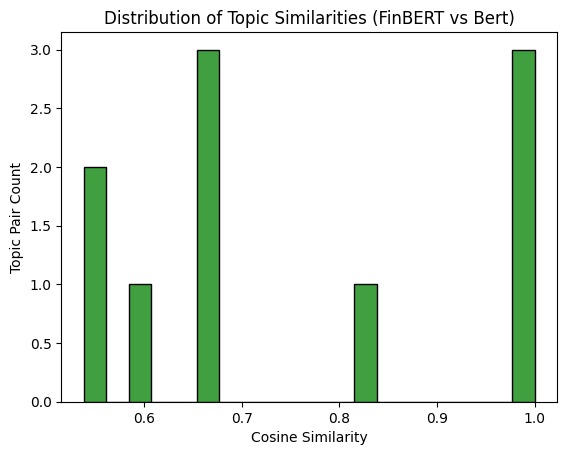

In [ ]:
#import seaborn as sns
#import matplotlib.pyplot as plt

# Plot histogram of cosine similarity scores to assess overlap between FinBERT and BertMPNet topics.

similarities = [match[2] for match in matches]
sns.histplot(similarities, bins=20, color='green')
plt.title("Distribution of Topic Similarities (FinBERT vs Bert)")
plt.xlabel("Cosine Similarity")
plt.ylabel("Topic Pair Count")
plt.show()

In [ ]:

trend_Hsbc = Hsbc_df[Hsbc_df['topic_finbert'].isin(matched_ids)]
Hsbc_trend_summary = trend_Hsbc.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
Hsbc_trend_summary

,year,quarter,topic_finbert,count
0,2023,Q1,1,2
1,2023,Q1,14,1
2,2023,Q1,23,1
3,2023,Q1,26,1
4,2023,Q1,27,1
...,...,...,...,...
109,2025,Q2,77,1
110,2025,Q2,82,1
111,2025,Q2,90,1
112,2025,Q2,94,1


In [ ]:
# HSBC
hsbc_summary = Hsbc_df.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
hsbc_summary['bank'] = 'HSBC'

# JPMorgan
jpm_summary = df_filtered.groupby(['year', 'quarter', 'topic_finbert']).size().reset_index(name='count')
jpm_summary['bank'] = 'JPMorgan'

# Combine
combined_summary = pd.concat([hsbc_summary, jpm_summary])


### Graphs & Visuals

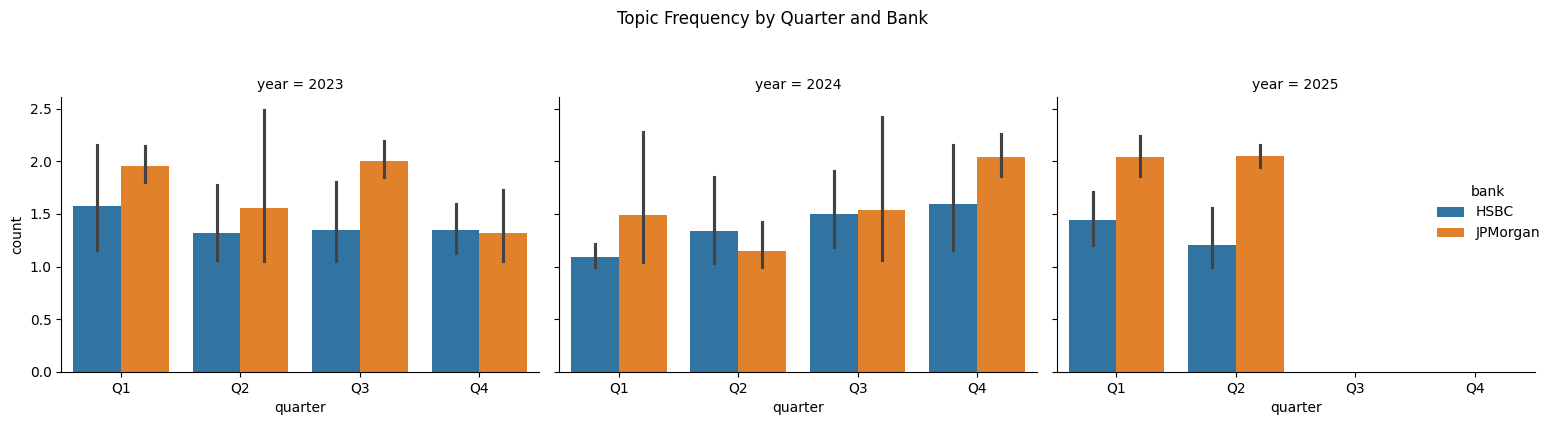

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=combined_summary, x='quarter', y='count', hue='bank', col='year', kind='bar', height=4, aspect=1.2)
plt.suptitle("Topic Frequency by Quarter and Bank", y=1.05)
plt.tight_layout()
plt.show()


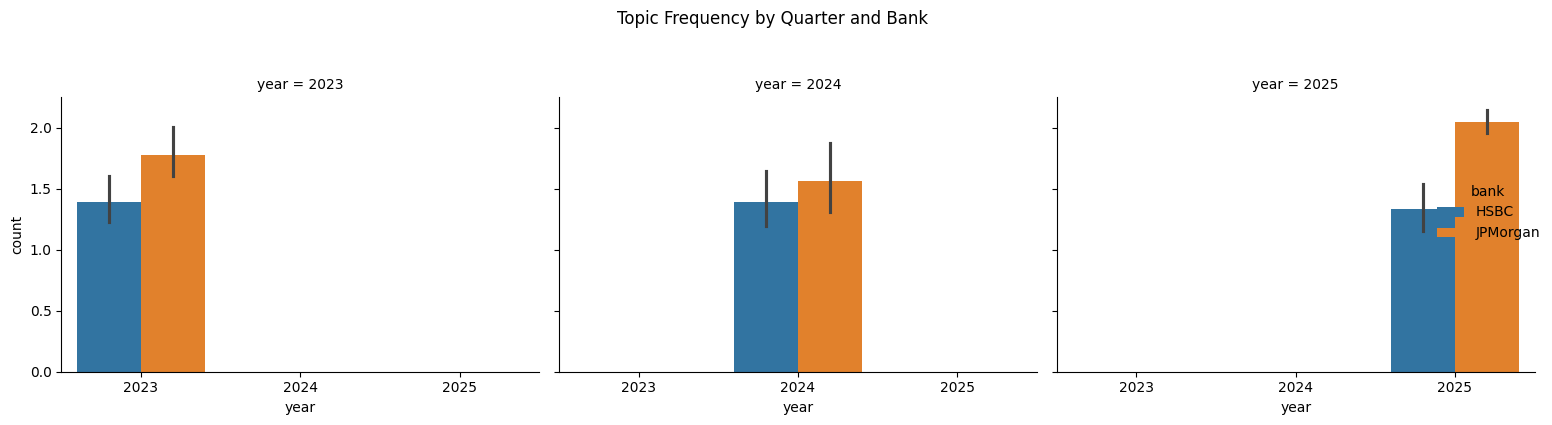

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.catplot(data=combined_summary, x='year', y='count', hue='bank', col='year', kind='bar', height=4, aspect=1.2)
plt.suptitle("Topic Frequency by Quarter and Bank", y=1.05)
plt.tight_layout()
plt.show()

In [ ]:
matched_ids = [match[0] for match in matches if match[2] >= 0.82]

hsbc_matched = Hsbc_df[Hsbc_df['topic_finbert'].isin(matched_ids)].copy()
jpm_matched = df_filtered[df_filtered['topic_finbert'].isin(matched_ids)].copy()

In [ ]:
hsbc_summary = hsbc_matched.groupby(['topic_finbert', 'year', 'quarter']).size().reset_index(name='hsbc_count')
jpm_summary = jpm_matched.groupby(['topic_finbert', 'year', 'quarter']).size().reset_index(name='jpm_count')

In [ ]:
comparison_df = pd.merge(hsbc_summary, jpm_summary, on=['topic_finbert', 'year', 'quarter'], how='outer').fillna(0)

# Add difference and ratio columns
comparison_df['count_diff'] = comparison_df['hsbc_count'] - comparison_df['jpm_count']
comparison_df['count_ratio'] = comparison_df['hsbc_count'] / (comparison_df['jpm_count'] + 1e-5)

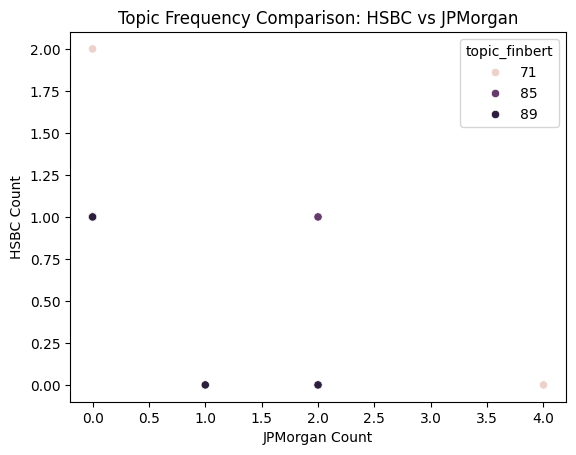

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=comparison_df, x='jpm_count', y='hsbc_count', hue='topic_finbert')
plt.title("Topic Frequency Comparison: HSBC vs JPMorgan")
plt.xlabel("JPMorgan Count")
plt.ylabel("HSBC Count")
plt.show()

In [ ]:
trend_summary = combined_summary.groupby(['year', 'quarter', 'topic_finbert', 'bank']).sum().reset_index()


In [ ]:
comparison_df['divergence'] = abs(comparison_df['hsbc_count'] - comparison_df['jpm_count'])


In [ ]:
Hsbc_df[Hsbc_df['topic_finbert'] == 1]['content'].head(3)

,content
13,I’ll deal with the second one later. I’ll as ...
23,Okay. Thank you. I’ll take the second in a m...
144,NEIL SANKOFF: We have time f or one last quest...


In [ ]:
for match in matches:
    hsbc_id, jpm_id, similarity_score = match
    print(hsbc_id, jpm_id, similarity_score)


1 0 0.8181818181818182
15 10 0.6666666666666666
35 66 0.6666666666666666
65 100 0.5384615384615384
67 44 0.6
71 74 1.0
82 88 0.5384615384615384
85 83 1.0
89 81 1.0
92 93 0.6666666666666666


In [ ]:
match_df = pd.DataFrame(matches, columns=['hsbc_topic', 'jpm_topic', 'similarity'])
match_df = match_df[match_df['similarity'] > 0.80]
match_df.head()


,hsbc_topic,jpm_topic,similarity
0,1,0,0.818182
5,71,74,1.000000
7,85,83,1.000000
8,89,81,1.000000


In [ ]:
finbert_model.get_topic(81)


[('reconciliation', 0.15811497416264172),
 ('andy', 0.12315201051473885),
 ('finish', 0.118297353462347),
 ('slide', 0.11401408776206047),
 ('revise', 0.10149371393656018),
 ('explain', 0.10149371393656018),
 ('specific', 0.09083099658403192),
 ('reiterate', 0.08746944618236813),
 ('fact', 0.08049256247817893),
 ('capture', 0.07813148616114791)]

In [ ]:
Hsbc_Fin_model.get_topic(89)

[('nasty', 0.04984810235715539),
 ('surprise', 0.04672593745289951),
 ('recruit', 0.04672593745289951),
 ('team', 0.04497502321406387),
 ('buy', 0.04023326703527648),
 ('past', 0.03823298344369774),
 ('acquisition', 0.03823298344369774),
 ('manual', 0.03617629744513861),
 ('diligence', 0.03617629744513861),
 ('quality', 0.03598001857125109)]